In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torchmetrics


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pickle

In [66]:
class EWC_loss(nn.Module):
    def __init__(self, model: nn.Module, information_matrix, lambda_ewc, loss_fn):
        super(EWC_loss, self).__init__()
        for name, param in model.named_parameters():
            self.register_buffer(self.get_orig_name(name), param.detach().clone())
            self.register_buffer(self.get_info_name(name), information_matrix[name])
        
        self.lambda_ewc = lambda_ewc
        self.loss_fn = loss_fn

    def get_orig_name(self, name):
        return f"orig_{name.replace('.', '_')}"
    
    def get_info_name(self, name):
        return f"info_{name.replace('.', '_')}"
    
    def forward(self, model, pred, target):
        # Compute the loss
        loss = self.loss_fn(pred, target)
        buffer = self.state_dict()
        
        # Compute the EWC penalty
        ewc_penalty = 0
        for name, param in model.named_parameters():
            old_param = buffer[self.get_orig_name(name)]
            information = buffer[self.get_info_name(name)]
            ewc_penalty += (information * (param - old_param) ** 2).sum()    
        # Combine the loss and the EWC penalty
        total_loss = loss + self.lambda_ewc * ewc_penalty
        
        return total_loss

In [67]:
from fisherunlearn.clients_utils import split_dataset_by_class_distribution, concatenate_subsets
from torch.utils.data import Subset

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

classes_datasets = split_dataset_by_class_distribution(train_dataset, np.identity(10))
classes_test_datasets = split_dataset_by_class_distribution(test_dataset, np.identity(10))

rounds_per_class=100
classes_rounds_datasets = []
for dataset in classes_datasets:
    classes_rounds_datasets.append([])
    indices = dataset.indices
    num_samples_per_round = np.floor(len(indices) / rounds_per_class+1).astype(int)
    for i in range(rounds_per_class+1):
        start = i * num_samples_per_round
        end = (i + 1) * num_samples_per_round
        classes_rounds_datasets[-1].append(Subset(train_dataset, indices[start:end]))

initial_datasets = [dataset.pop(0) for dataset in classes_rounds_datasets]
initial_dataset = concatenate_subsets(initial_datasets)

rounds_labels = []
for i in range(rounds_per_class):
    rounds_labels.extend(list(range(10)))
rounds_datasets = []
for label in rounds_labels:
    rounds_datasets.append(classes_rounds_datasets[label].pop(0))

print(f"Number of rounds: {len(rounds_datasets)}")





Number of rounds: 1000


In [68]:
class FLNet(nn.Sequential):
    def __init__(self):
        super(FLNet, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

test_model = FLNet()
model_parameters = filter(lambda p: p.requires_grad, test_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the model: {params}")

Number of parameters in the model: 1663370


In [69]:
def compute_accuracy(model, dataset, device=None):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device
        
    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_accuracies(model, datasets):
    accuracies = []
    for idx, dataset in enumerate(datasets):
        accuracy = compute_accuracy(model, dataset)
        accuracies.append(accuracy)
    return accuracies

# create validation routine
def validate(model, dataloaders, num_classes, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)
    # move metric to device
    model.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    model.eval()
    # at the end of epoch, validate model
    for loader_idx, loader in enumerate(dataloaders):
        for inputs, targets in loader:
        
            inputs = inputs.to(device)
            targets = targets.to(device)
            # remove singleton dimension
            targets = targets.squeeze()
            # get output
            with torch.no_grad():
                # perform prediction
                logits = model(inputs)
            # update metrics
            _, predicted = torch.max(logits.data, 1)
            tm_acc.update(predicted, targets)
            tm_con.update(predicted, targets)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    
    return acc, con


def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)

In [70]:
def trainer(model, loss_fn, dataset, epochs):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    #device = "cpu"
    model.to(device)

    for epoch in range(epochs):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
        
    return model

def trainer_ewc(model, loss_fn, dataset, epochs):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.5*1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    #device = "cpu"
    model.to(device)
    loss_fn.to(device)
    model.train()
    for epoch in range(epochs):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(model, preds, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
    
    model.eval()
    return model

In [71]:
def get_normalized_information(information):
    normalized_info = dict(information)
    total_num_params = sum([p.numel() for p in information.values()])
    for name, param in normalized_info.items():
        info = normalized_info[name]
        # Softmax normalization
        info = torch.exp(info)
        info = info / torch.sum(info)
        # Normalize by the number of parameters in the layer
        info = info * info.numel() / total_num_params
        normalized_info[name] = info
    
    return normalized_info

In [72]:
torch.cuda.empty_cache()

# Model
model = FLNet()
model_benchmark = FLNet()
loss_fn = nn.CrossEntropyLoss()

model_benchmark = trainer(model_benchmark, loss_fn, train_dataset, 5)
model = trainer(model, loss_fn, initial_dataset, 5)


cuda
Epoch 1/5, Loss: 0.0087
Epoch 2/5, Loss: 0.1208
Epoch 3/5, Loss: 0.0017
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0153
cuda
Epoch 1/5, Loss: 1.4172
Epoch 2/5, Loss: 0.8971
Epoch 3/5, Loss: 0.5578
Epoch 4/5, Loss: 0.2051
Epoch 5/5, Loss: 0.1785


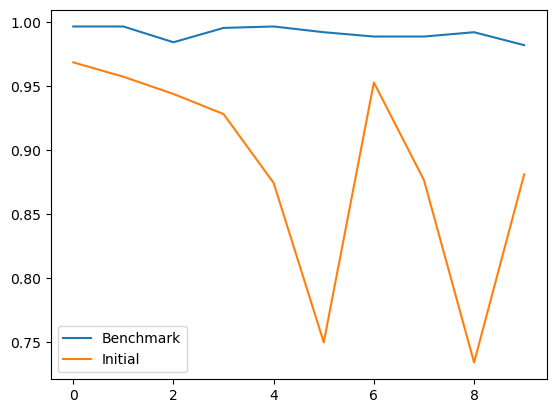

In [73]:
benchmark_accuracies = compute_accuracies(model_benchmark, classes_test_datasets)
plt.plot(benchmark_accuracies, label="Benchmark")
plt.plot(compute_accuracies(model, classes_test_datasets), label="Initial")
plt.legend()
plt.show()

Computing clients information:   0%|          | 0/18 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1307
Epoch 2/10, Loss: 15.1176
Epoch 3/10, Loss: 1.1479
Epoch 4/10, Loss: 3.4226
Epoch 5/10, Loss: 8.7956
Epoch 6/10, Loss: 6.4486
Epoch 7/10, Loss: 1.8709
Epoch 8/10, Loss: 0.2497
Epoch 9/10, Loss: 2.1201
Epoch 10/10, Loss: 4.2491


Computing clients information:   0%|          | 0/18 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1307
Epoch 2/10, Loss: 66.9105
Epoch 3/10, Loss: 4.5075
Epoch 4/10, Loss: 14.3823
Epoch 5/10, Loss: 38.6278
Epoch 6/10, Loss: 29.1228
Epoch 7/10, Loss: 8.4810
Epoch 8/10, Loss: 0.2678
Epoch 9/10, Loss: 8.1834
Epoch 10/10, Loss: 18.1614
cuda
Epoch 1/5, Loss: 0.1307
Epoch 2/5, Loss: 0.0017
Epoch 3/5, Loss: 0.0000
Epoch 4/5, Loss: 0.0000
Epoch 5/5, Loss: 0.0000


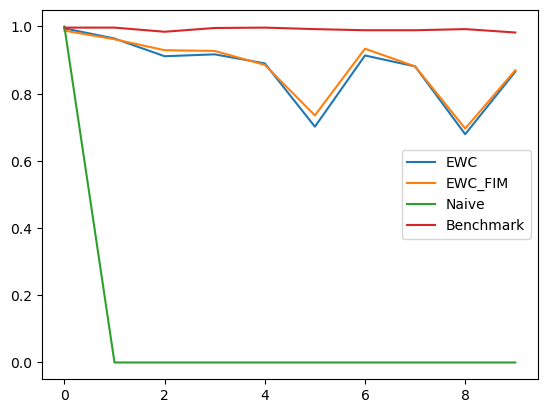

Computing clients information:   0%|          | 0/20 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.0414
Epoch 2/10, Loss: 13.5318
Epoch 3/10, Loss: 0.9808
Epoch 4/10, Loss: 3.0255
Epoch 5/10, Loss: 7.9236
Epoch 6/10, Loss: 5.7781
Epoch 7/10, Loss: 1.6536
Epoch 8/10, Loss: 0.2053
Epoch 9/10, Loss: 1.8691
Epoch 10/10, Loss: 3.7658


Computing clients information:   0%|          | 0/19 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.0432
Epoch 2/10, Loss: 64.9490
Epoch 3/10, Loss: 4.2992
Epoch 4/10, Loss: 13.8666
Epoch 5/10, Loss: 37.4518
Epoch 6/10, Loss: 28.3599
Epoch 7/10, Loss: 8.2498
Epoch 8/10, Loss: 0.1371
Epoch 9/10, Loss: 7.7885
Epoch 10/10, Loss: 17.5476
cuda
Epoch 1/5, Loss: 9.0160
Epoch 2/5, Loss: 1.1873
Epoch 3/5, Loss: 0.0209
Epoch 4/5, Loss: 0.0013
Epoch 5/5, Loss: 0.0008


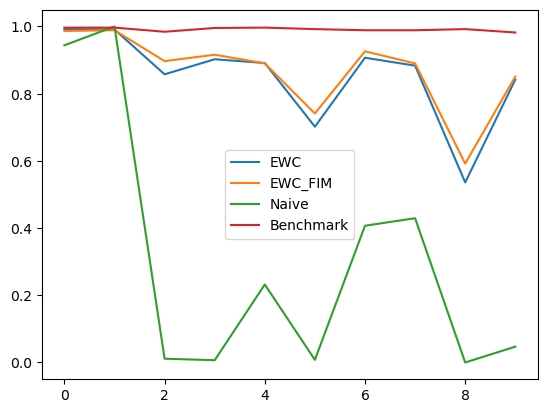

Computing clients information:   0%|          | 0/21 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7718
Epoch 2/10, Loss: 15.1600
Epoch 3/10, Loss: 1.6824
Epoch 4/10, Loss: 3.6700
Epoch 5/10, Loss: 8.8548
Epoch 6/10, Loss: 6.6805
Epoch 7/10, Loss: 2.2315
Epoch 8/10, Loss: 0.6949
Epoch 9/10, Loss: 2.5509
Epoch 10/10, Loss: 4.5421


Computing clients information:   0%|          | 0/21 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6542
Epoch 2/10, Loss: 63.1710
Epoch 3/10, Loss: 4.7256
Epoch 4/10, Loss: 13.9175
Epoch 5/10, Loss: 36.5830
Epoch 6/10, Loss: 27.7991
Epoch 7/10, Loss: 8.4335
Epoch 8/10, Loss: 0.7217
Epoch 9/10, Loss: 8.1914
Epoch 10/10, Loss: 17.5035
cuda
Epoch 1/5, Loss: 5.3591
Epoch 2/5, Loss: 1.2733
Epoch 3/5, Loss: 0.2291
Epoch 4/5, Loss: 0.0584
Epoch 5/5, Loss: 0.0163


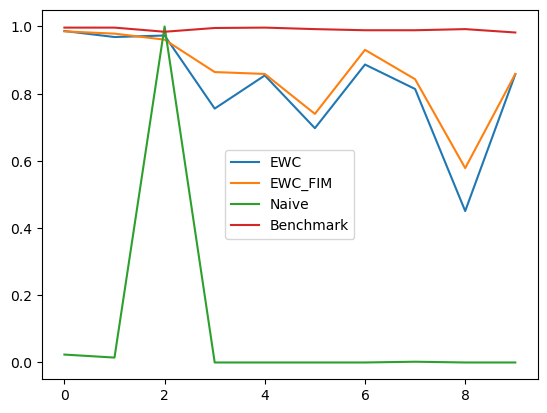

Computing clients information:   0%|          | 0/23 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7082
Epoch 2/10, Loss: 15.0855
Epoch 3/10, Loss: 1.5344
Epoch 4/10, Loss: 3.3728
Epoch 5/10, Loss: 8.5793
Epoch 6/10, Loss: 6.3656
Epoch 7/10, Loss: 1.9525
Epoch 8/10, Loss: 0.4786
Epoch 9/10, Loss: 2.3174
Epoch 10/10, Loss: 4.2692


Computing clients information:   0%|          | 0/23 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3571
Epoch 2/10, Loss: 64.1784
Epoch 3/10, Loss: 4.5301
Epoch 4/10, Loss: 13.9603
Epoch 5/10, Loss: 37.0423
Epoch 6/10, Loss: 27.9586
Epoch 7/10, Loss: 8.2200
Epoch 8/10, Loss: 0.4886
Epoch 9/10, Loss: 8.1580
Epoch 10/10, Loss: 17.5811
cuda
Epoch 1/5, Loss: 5.5816
Epoch 2/5, Loss: 2.3021
Epoch 3/5, Loss: 1.0442
Epoch 4/5, Loss: 0.6217
Epoch 5/5, Loss: 0.3957


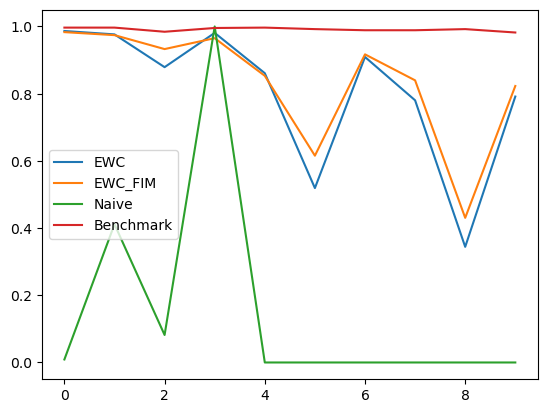

Computing clients information:   0%|          | 0/25 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3603
Epoch 2/10, Loss: 14.8569
Epoch 3/10, Loss: 1.2842
Epoch 4/10, Loss: 3.3324
Epoch 5/10, Loss: 8.5921
Epoch 6/10, Loss: 6.3601
Epoch 7/10, Loss: 1.9287
Epoch 8/10, Loss: 0.3921
Epoch 9/10, Loss: 2.2006
Epoch 10/10, Loss: 4.2136


Computing clients information:   0%|          | 0/25 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3714
Epoch 2/10, Loss: 67.2936
Epoch 3/10, Loss: 4.7492
Epoch 4/10, Loss: 14.6358
Epoch 5/10, Loss: 38.8626
Epoch 6/10, Loss: 29.3357
Epoch 7/10, Loss: 8.6541
Epoch 8/10, Loss: 0.5249
Epoch 9/10, Loss: 8.5279
Epoch 10/10, Loss: 18.4258
cuda
Epoch 1/5, Loss: 2.3196
Epoch 2/5, Loss: 1.6137
Epoch 3/5, Loss: 1.1176
Epoch 4/5, Loss: 0.5997
Epoch 5/5, Loss: 0.2096


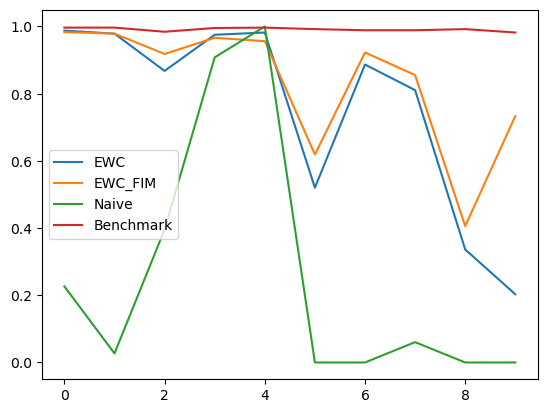

Computing clients information:   0%|          | 0/27 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.5780
Epoch 2/10, Loss: 14.8474
Epoch 3/10, Loss: 2.1706
Epoch 4/10, Loss: 3.6532
Epoch 5/10, Loss: 8.4873
Epoch 6/10, Loss: 6.4209
Epoch 7/10, Loss: 2.2391
Epoch 8/10, Loss: 0.8882
Epoch 9/10, Loss: 2.6701
Epoch 10/10, Loss: 4.4242


Computing clients information:   0%|          | 0/26 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2075
Epoch 2/10, Loss: 67.2603
Epoch 3/10, Loss: 5.4509
Epoch 4/10, Loss: 15.0608
Epoch 5/10, Loss: 39.0156
Epoch 6/10, Loss: 29.5812
Epoch 7/10, Loss: 9.1696
Epoch 8/10, Loss: 1.2785
Epoch 9/10, Loss: 9.2412
Epoch 10/10, Loss: 18.8645
cuda
Epoch 1/5, Loss: 3.4925
Epoch 2/5, Loss: 1.8548
Epoch 3/5, Loss: 1.1865
Epoch 4/5, Loss: 0.7442
Epoch 5/5, Loss: 0.3832


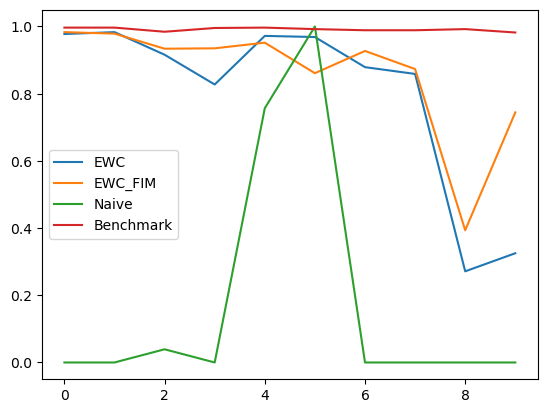

Computing clients information:   0%|          | 0/28 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2959
Epoch 2/10, Loss: 14.6523
Epoch 3/10, Loss: 1.2211
Epoch 4/10, Loss: 3.2959
Epoch 5/10, Loss: 8.4720
Epoch 6/10, Loss: 6.2519
Epoch 7/10, Loss: 1.8648
Epoch 8/10, Loss: 0.3604
Epoch 9/10, Loss: 2.1638
Epoch 10/10, Loss: 4.1494


Computing clients information:   0%|          | 0/28 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1902
Epoch 2/10, Loss: 66.0125
Epoch 3/10, Loss: 4.5044
Epoch 4/10, Loss: 14.2274
Epoch 5/10, Loss: 38.0894
Epoch 6/10, Loss: 28.7362
Epoch 7/10, Loss: 8.3919
Epoch 8/10, Loss: 0.3333
Epoch 9/10, Loss: 8.1624
Epoch 10/10, Loss: 17.9558
cuda
Epoch 1/5, Loss: 2.8313
Epoch 2/5, Loss: 1.7576
Epoch 3/5, Loss: 1.3265
Epoch 4/5, Loss: 0.9628
Epoch 5/5, Loss: 0.5789


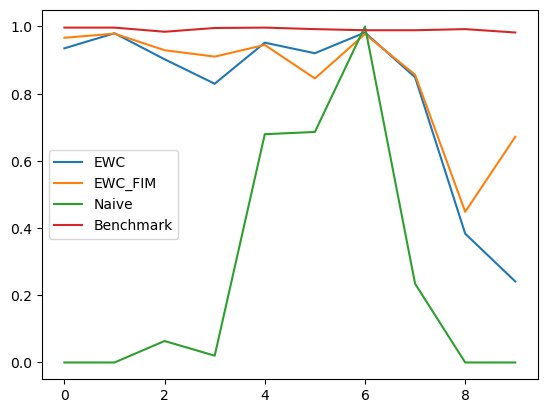

Computing clients information:   0%|          | 0/30 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6810
Epoch 2/10, Loss: 14.9936
Epoch 3/10, Loss: 1.5425
Epoch 4/10, Loss: 3.5603
Epoch 5/10, Loss: 8.7347
Epoch 6/10, Loss: 6.5451
Epoch 7/10, Loss: 2.1432
Epoch 8/10, Loss: 0.6153
Epoch 9/10, Loss: 2.4340
Epoch 10/10, Loss: 4.4196


Computing clients information:   0%|          | 0/30 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5505
Epoch 2/10, Loss: 62.7432
Epoch 3/10, Loss: 4.6072
Epoch 4/10, Loss: 13.7618
Epoch 5/10, Loss: 36.2923
Epoch 6/10, Loss: 27.5142
Epoch 7/10, Loss: 8.2685
Epoch 8/10, Loss: 0.6540
Epoch 9/10, Loss: 8.0778
Epoch 10/10, Loss: 17.3057
cuda
Epoch 1/5, Loss: 2.2035
Epoch 2/5, Loss: 1.5821
Epoch 3/5, Loss: 1.0325
Epoch 4/5, Loss: 0.5095
Epoch 5/5, Loss: 0.1671


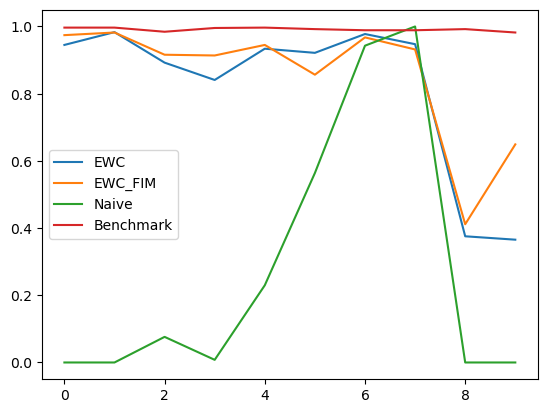

Computing clients information:   0%|          | 0/32 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.9677
Epoch 2/10, Loss: 14.0429
Epoch 3/10, Loss: 2.4315
Epoch 4/10, Loss: 3.3963
Epoch 5/10, Loss: 8.0480
Epoch 6/10, Loss: 6.3224
Epoch 7/10, Loss: 2.3933
Epoch 8/10, Loss: 1.0288
Epoch 9/10, Loss: 2.6260
Epoch 10/10, Loss: 4.2813


Computing clients information:   0%|          | 0/31 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.9039
Epoch 2/10, Loss: 59.6001
Epoch 3/10, Loss: 5.5263
Epoch 4/10, Loss: 13.6558
Epoch 5/10, Loss: 34.6417
Epoch 6/10, Loss: 26.3893
Epoch 7/10, Loss: 8.5080
Epoch 8/10, Loss: 1.7992
Epoch 9/10, Loss: 8.8816
Epoch 10/10, Loss: 17.0809
cuda
Epoch 1/5, Loss: 4.6091
Epoch 2/5, Loss: 2.6450
Epoch 3/5, Loss: 1.9439
Epoch 4/5, Loss: 1.6213
Epoch 5/5, Loss: 1.3537


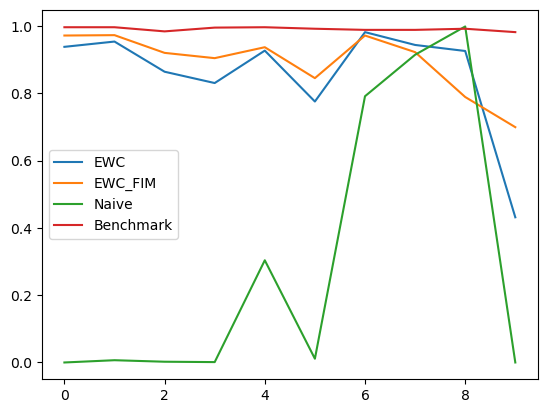

Computing clients information:   0%|          | 0/33 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.7063
Epoch 2/10, Loss: 14.2151
Epoch 3/10, Loss: 2.2538
Epoch 4/10, Loss: 3.5863
Epoch 5/10, Loss: 8.2089
Epoch 6/10, Loss: 6.2786
Epoch 7/10, Loss: 2.3197
Epoch 8/10, Loss: 1.0519
Epoch 9/10, Loss: 2.7009
Epoch 10/10, Loss: 4.3581


Computing clients information:   0%|          | 0/33 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.0772
Epoch 2/10, Loss: 62.4479
Epoch 3/10, Loss: 5.0632
Epoch 4/10, Loss: 14.0498
Epoch 5/10, Loss: 36.2363
Epoch 6/10, Loss: 27.3795
Epoch 7/10, Loss: 8.4527
Epoch 8/10, Loss: 1.2359
Epoch 9/10, Loss: 8.6717
Epoch 10/10, Loss: 17.5474
cuda
Epoch 1/5, Loss: 2.7072
Epoch 2/5, Loss: 2.2355
Epoch 3/5, Loss: 2.0314
Epoch 4/5, Loss: 1.8467
Epoch 5/5, Loss: 1.5863


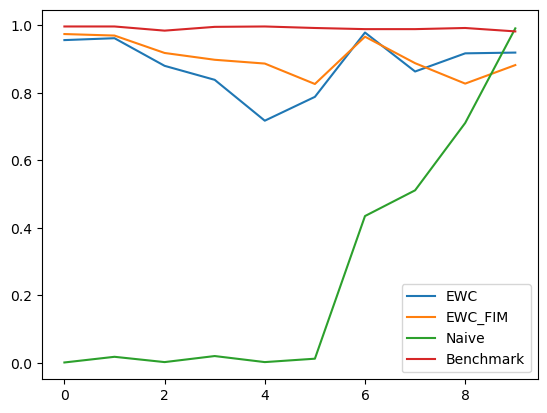

Computing clients information:   0%|          | 0/35 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1968
Epoch 2/10, Loss: 14.6250
Epoch 3/10, Loss: 1.1476
Epoch 4/10, Loss: 3.3106
Epoch 5/10, Loss: 8.5073
Epoch 6/10, Loss: 6.3074
Epoch 7/10, Loss: 1.8933
Epoch 8/10, Loss: 0.2894
Epoch 9/10, Loss: 2.0786
Epoch 10/10, Loss: 4.1299


Computing clients information:   0%|          | 0/35 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1506
Epoch 2/10, Loss: 60.1304
Epoch 3/10, Loss: 4.0757
Epoch 4/10, Loss: 12.9039
Epoch 5/10, Loss: 34.6785
Epoch 6/10, Loss: 26.3318
Epoch 7/10, Loss: 7.7548
Epoch 8/10, Loss: 0.2123
Epoch 9/10, Loss: 7.2746
Epoch 10/10, Loss: 16.3079
cuda
Epoch 1/5, Loss: 2.0988
Epoch 2/5, Loss: 1.4905
Epoch 3/5, Loss: 0.8511
Epoch 4/5, Loss: 0.3254
Epoch 5/5, Loss: 0.0935


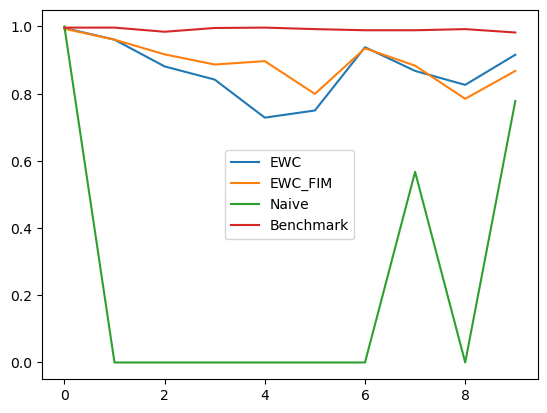

Computing clients information:   0%|          | 0/37 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1510
Epoch 2/10, Loss: 13.5218
Epoch 3/10, Loss: 1.1135
Epoch 4/10, Loss: 3.0666
Epoch 5/10, Loss: 7.9721
Epoch 6/10, Loss: 5.9121
Epoch 7/10, Loss: 1.7836
Epoch 8/10, Loss: 0.3110
Epoch 9/10, Loss: 1.9488
Epoch 10/10, Loss: 3.8465


Computing clients information:   0%|          | 0/37 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1358
Epoch 2/10, Loss: 63.3760
Epoch 3/10, Loss: 4.2809
Epoch 4/10, Loss: 13.5925
Epoch 5/10, Loss: 36.5795
Epoch 6/10, Loss: 27.7436
Epoch 7/10, Loss: 8.1312
Epoch 8/10, Loss: 0.2053
Epoch 9/10, Loss: 7.6688
Epoch 10/10, Loss: 17.1951
cuda
Epoch 1/5, Loss: 2.8882
Epoch 2/5, Loss: 1.6881
Epoch 3/5, Loss: 0.9665
Epoch 4/5, Loss: 0.4577
Epoch 5/5, Loss: 0.1596


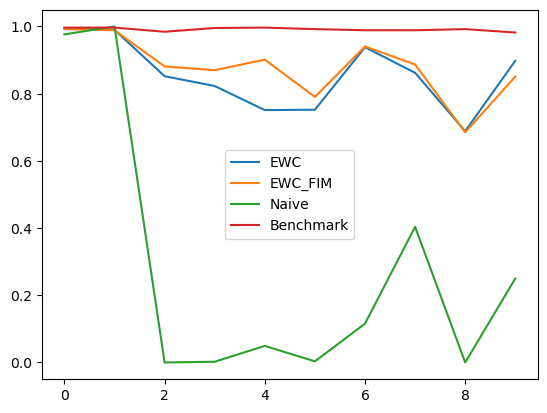

Computing clients information:   0%|          | 0/39 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4088
Epoch 2/10, Loss: 14.3913
Epoch 3/10, Loss: 1.3428
Epoch 4/10, Loss: 3.2654
Epoch 5/10, Loss: 8.3360
Epoch 6/10, Loss: 6.2502
Epoch 7/10, Loss: 1.9189
Epoch 8/10, Loss: 0.3964
Epoch 9/10, Loss: 2.1763
Epoch 10/10, Loss: 4.1267


Computing clients information:   0%|          | 0/38 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2594
Epoch 2/10, Loss: 63.1865
Epoch 3/10, Loss: 4.3751
Epoch 4/10, Loss: 13.6575
Epoch 5/10, Loss: 36.4564
Epoch 6/10, Loss: 27.6443
Epoch 7/10, Loss: 8.1461
Epoch 8/10, Loss: 0.3417
Epoch 9/10, Loss: 7.8405
Epoch 10/10, Loss: 17.2404
cuda
Epoch 1/5, Loss: 3.7592
Epoch 2/5, Loss: 2.2628
Epoch 3/5, Loss: 1.5526
Epoch 4/5, Loss: 1.0165
Epoch 5/5, Loss: 0.5145


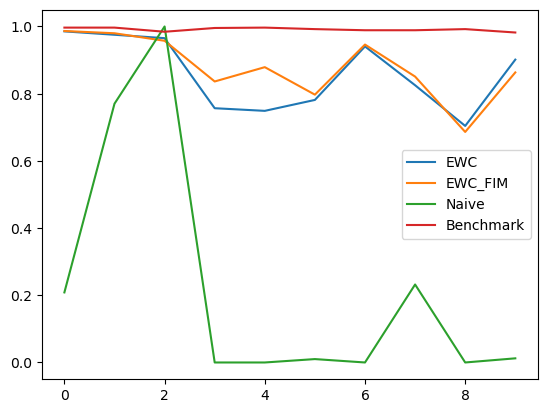

Computing clients information:   0%|          | 0/41 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7057
Epoch 2/10, Loss: 14.3183
Epoch 3/10, Loss: 1.5060
Epoch 4/10, Loss: 3.3387
Epoch 5/10, Loss: 8.2772
Epoch 6/10, Loss: 6.1852
Epoch 7/10, Loss: 1.9886
Epoch 8/10, Loss: 0.5548
Epoch 9/10, Loss: 2.2996
Epoch 10/10, Loss: 4.1629


Computing clients information:   0%|          | 0/40 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4979
Epoch 2/10, Loss: 63.6927
Epoch 3/10, Loss: 4.6192
Epoch 4/10, Loss: 13.9443
Epoch 5/10, Loss: 36.8248
Epoch 6/10, Loss: 27.8806
Epoch 7/10, Loss: 8.3176
Epoch 8/10, Loss: 0.5997
Epoch 9/10, Loss: 8.1827
Epoch 10/10, Loss: 17.5571
cuda
Epoch 1/5, Loss: 2.2217
Epoch 2/5, Loss: 1.5445
Epoch 3/5, Loss: 1.1308
Epoch 4/5, Loss: 0.6781
Epoch 5/5, Loss: 0.2824


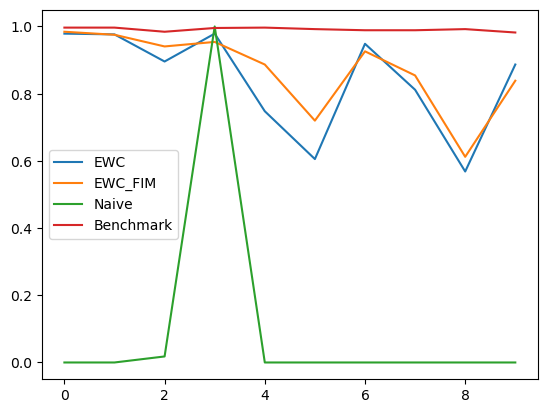

Computing clients information:   0%|          | 0/42 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7949
Epoch 2/10, Loss: 14.6767
Epoch 3/10, Loss: 1.6111
Epoch 4/10, Loss: 3.4603
Epoch 5/10, Loss: 8.5136
Epoch 6/10, Loss: 6.3778
Epoch 7/10, Loss: 2.1022
Epoch 8/10, Loss: 0.6369
Epoch 9/10, Loss: 2.4034
Epoch 10/10, Loss: 4.3138


Computing clients information:   0%|          | 0/42 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5250
Epoch 2/10, Loss: 69.6670
Epoch 3/10, Loss: 5.0406
Epoch 4/10, Loss: 15.2279
Epoch 5/10, Loss: 40.2923
Epoch 6/10, Loss: 30.5620
Epoch 7/10, Loss: 9.1432
Epoch 8/10, Loss: 0.6204
Epoch 9/10, Loss: 8.8735
Epoch 10/10, Loss: 19.1771
cuda
Epoch 1/5, Loss: 2.8800
Epoch 2/5, Loss: 1.7738
Epoch 3/5, Loss: 1.2188
Epoch 4/5, Loss: 0.7575
Epoch 5/5, Loss: 0.3615


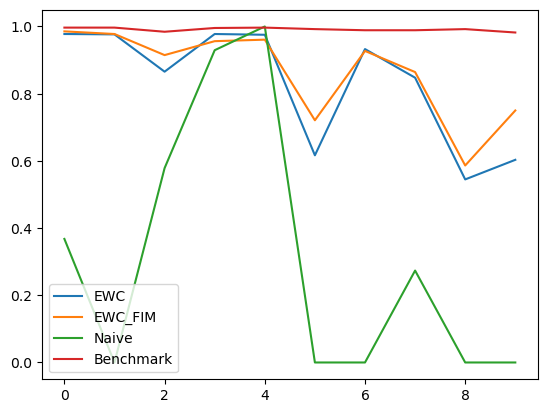

Computing clients information:   0%|          | 0/44 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6956
Epoch 2/10, Loss: 14.2437
Epoch 3/10, Loss: 1.5011
Epoch 4/10, Loss: 3.2216
Epoch 5/10, Loss: 8.1346
Epoch 6/10, Loss: 6.0410
Epoch 7/10, Loss: 1.8682
Epoch 8/10, Loss: 0.4934
Epoch 9/10, Loss: 2.2432
Epoch 10/10, Loss: 4.0705


Computing clients information:   0%|          | 0/43 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4614
Epoch 2/10, Loss: 66.1896
Epoch 3/10, Loss: 4.7618
Epoch 4/10, Loss: 14.4465
Epoch 5/10, Loss: 38.2169
Epoch 6/10, Loss: 28.8388
Epoch 7/10, Loss: 8.5252
Epoch 8/10, Loss: 0.6193
Epoch 9/10, Loss: 8.5301
Epoch 10/10, Loss: 18.1791
cuda
Epoch 1/5, Loss: 2.7534
Epoch 2/5, Loss: 1.5928
Epoch 3/5, Loss: 1.0066
Epoch 4/5, Loss: 0.5458
Epoch 5/5, Loss: 0.2240


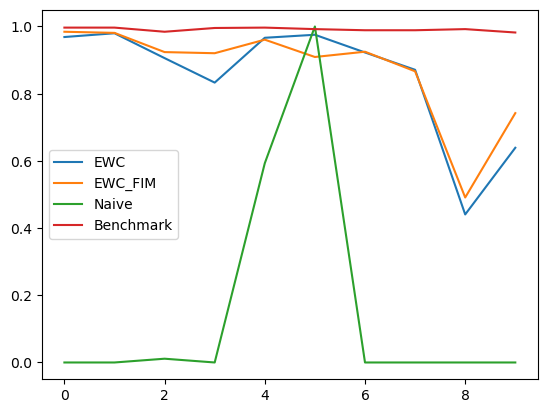

Computing clients information:   0%|          | 0/46 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1239
Epoch 2/10, Loss: 13.9796
Epoch 3/10, Loss: 1.0621
Epoch 4/10, Loss: 3.0895
Epoch 5/10, Loss: 8.1239
Epoch 6/10, Loss: 5.9384
Epoch 7/10, Loss: 1.7235
Epoch 8/10, Loss: 0.2575
Epoch 9/10, Loss: 1.9657
Epoch 10/10, Loss: 3.8982


Computing clients information:   0%|          | 0/45 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1076
Epoch 2/10, Loss: 67.0256
Epoch 3/10, Loss: 4.4930
Epoch 4/10, Loss: 14.4300
Epoch 5/10, Loss: 38.6566
Epoch 6/10, Loss: 29.1236
Epoch 7/10, Loss: 8.4277
Epoch 8/10, Loss: 0.2587
Epoch 9/10, Loss: 8.2327
Epoch 10/10, Loss: 18.1829
cuda
Epoch 1/5, Loss: 2.8826
Epoch 2/5, Loss: 1.6396
Epoch 3/5, Loss: 1.1041
Epoch 4/5, Loss: 0.7117
Epoch 5/5, Loss: 0.3741


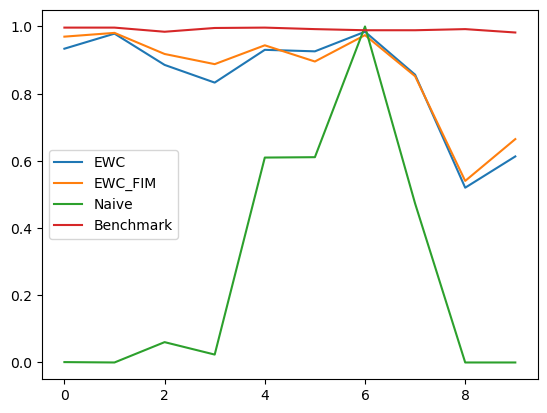

Computing clients information:   0%|          | 0/47 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3953
Epoch 2/10, Loss: 13.8199
Epoch 3/10, Loss: 1.2446
Epoch 4/10, Loss: 3.1622
Epoch 5/10, Loss: 8.0246
Epoch 6/10, Loss: 5.9963
Epoch 7/10, Loss: 1.8627
Epoch 8/10, Loss: 0.3934
Epoch 9/10, Loss: 2.0805
Epoch 10/10, Loss: 3.9609


Computing clients information:   0%|          | 0/47 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4185
Epoch 2/10, Loss: 67.5211
Epoch 3/10, Loss: 4.7957
Epoch 4/10, Loss: 14.6738
Epoch 5/10, Loss: 39.0018
Epoch 6/10, Loss: 29.6138
Epoch 7/10, Loss: 8.8285
Epoch 8/10, Loss: 0.4974
Epoch 9/10, Loss: 8.4848
Epoch 10/10, Loss: 18.5084
cuda
Epoch 1/5, Loss: 1.7787
Epoch 2/5, Loss: 0.9842
Epoch 3/5, Loss: 0.4005
Epoch 4/5, Loss: 0.0993
Epoch 5/5, Loss: 0.0157


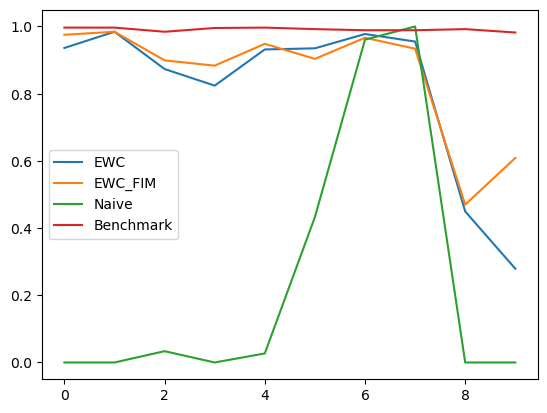

Computing clients information:   0%|          | 0/49 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.6297
Epoch 2/10, Loss: 13.8024
Epoch 3/10, Loss: 2.2234
Epoch 4/10, Loss: 3.2694
Epoch 5/10, Loss: 7.9106
Epoch 6/10, Loss: 6.1450
Epoch 7/10, Loss: 2.2156
Epoch 8/10, Loss: 0.8858
Epoch 9/10, Loss: 2.4893
Epoch 10/10, Loss: 4.1423


Computing clients information:   0%|          | 0/49 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.5588
Epoch 2/10, Loss: 65.9346
Epoch 3/10, Loss: 5.6710
Epoch 4/10, Loss: 14.8974
Epoch 5/10, Loss: 38.2155
Epoch 6/10, Loss: 29.0043
Epoch 7/10, Loss: 9.0733
Epoch 8/10, Loss: 1.5706
Epoch 9/10, Loss: 9.4814
Epoch 10/10, Loss: 18.6625
cuda
Epoch 1/5, Loss: 5.6535
Epoch 2/5, Loss: 2.6203
Epoch 3/5, Loss: 1.4235
Epoch 4/5, Loss: 0.9008
Epoch 5/5, Loss: 0.5601


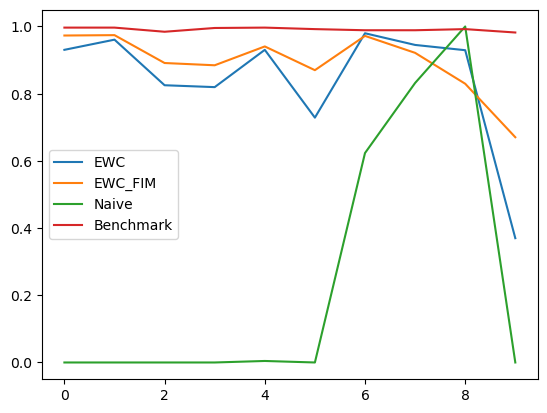

Computing clients information:   0%|          | 0/51 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.7594
Epoch 2/10, Loss: 13.6651
Epoch 3/10, Loss: 2.2614
Epoch 4/10, Loss: 3.5384
Epoch 5/10, Loss: 7.9589
Epoch 6/10, Loss: 6.1284
Epoch 7/10, Loss: 2.3215
Epoch 8/10, Loss: 1.0761
Epoch 9/10, Loss: 2.6466
Epoch 10/10, Loss: 4.2451


Computing clients information:   0%|          | 0/50 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.1478
Epoch 2/10, Loss: 66.7479
Epoch 3/10, Loss: 5.3978
Epoch 4/10, Loss: 15.0049
Epoch 5/10, Loss: 38.7446
Epoch 6/10, Loss: 29.3735
Epoch 7/10, Loss: 9.0975
Epoch 8/10, Loss: 1.2634
Epoch 9/10, Loss: 9.1955
Epoch 10/10, Loss: 18.7642
cuda
Epoch 1/5, Loss: 3.0999
Epoch 2/5, Loss: 2.1298
Epoch 3/5, Loss: 1.7574
Epoch 4/5, Loss: 1.5130
Epoch 5/5, Loss: 1.2319


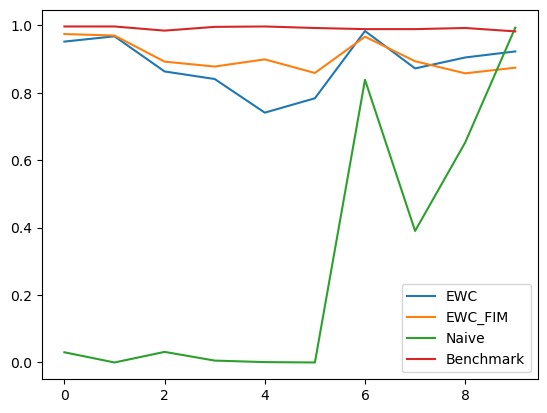

Computing clients information:   0%|          | 0/53 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3999
Epoch 2/10, Loss: 14.4421
Epoch 3/10, Loss: 1.2962
Epoch 4/10, Loss: 3.3053
Epoch 5/10, Loss: 8.3878
Epoch 6/10, Loss: 6.2376
Epoch 7/10, Loss: 1.9301
Epoch 8/10, Loss: 0.4362
Epoch 9/10, Loss: 2.1991
Epoch 10/10, Loss: 4.1501


Computing clients information:   0%|          | 0/52 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2921
Epoch 2/10, Loss: 65.4226
Epoch 3/10, Loss: 4.5579
Epoch 4/10, Loss: 14.1604
Epoch 5/10, Loss: 37.7725
Epoch 6/10, Loss: 28.6338
Epoch 7/10, Loss: 8.4677
Epoch 8/10, Loss: 0.3951
Epoch 9/10, Loss: 8.1324
Epoch 10/10, Loss: 17.8635
cuda
Epoch 1/5, Loss: 1.8742
Epoch 2/5, Loss: 1.1533
Epoch 3/5, Loss: 0.5502
Epoch 4/5, Loss: 0.1836
Epoch 5/5, Loss: 0.0423


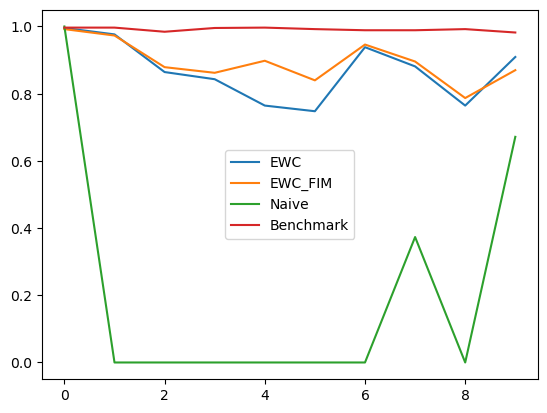

Computing clients information:   0%|          | 0/55 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1045
Epoch 2/10, Loss: 12.0144
Epoch 3/10, Loss: 0.9943
Epoch 4/10, Loss: 2.6900
Epoch 5/10, Loss: 7.1000
Epoch 6/10, Loss: 5.2696
Epoch 7/10, Loss: 1.5774
Epoch 8/10, Loss: 0.2567
Epoch 9/10, Loss: 1.7145
Epoch 10/10, Loss: 3.4036


Computing clients information:   0%|          | 0/54 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.0889
Epoch 2/10, Loss: 68.6468
Epoch 3/10, Loss: 4.5847
Epoch 4/10, Loss: 14.6920
Epoch 5/10, Loss: 39.6390
Epoch 6/10, Loss: 30.0633
Epoch 7/10, Loss: 8.8340
Epoch 8/10, Loss: 0.2143
Epoch 9/10, Loss: 8.2590
Epoch 10/10, Loss: 18.5778
cuda
Epoch 1/5, Loss: 3.7515
Epoch 2/5, Loss: 1.9104
Epoch 3/5, Loss: 0.9353
Epoch 4/5, Loss: 0.3953
Epoch 5/5, Loss: 0.1359


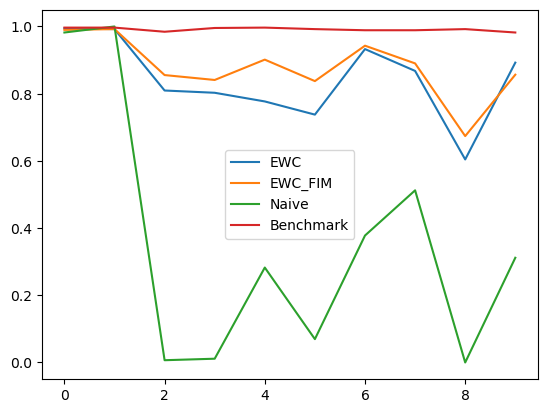

Computing clients information:   0%|          | 0/56 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.8407
Epoch 2/10, Loss: 14.4417
Epoch 3/10, Loss: 1.5994
Epoch 4/10, Loss: 3.4026
Epoch 5/10, Loss: 8.3419
Epoch 6/10, Loss: 6.2785
Epoch 7/10, Loss: 2.0545
Epoch 8/10, Loss: 0.6346
Epoch 9/10, Loss: 2.3866
Epoch 10/10, Loss: 4.2247


Computing clients information:   0%|          | 0/55 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6287
Epoch 2/10, Loss: 70.8937
Epoch 3/10, Loss: 5.1978
Epoch 4/10, Loss: 15.5127
Epoch 5/10, Loss: 40.9777
Epoch 6/10, Loss: 31.0996
Epoch 7/10, Loss: 9.3554
Epoch 8/10, Loss: 0.7225
Epoch 9/10, Loss: 9.1113
Epoch 10/10, Loss: 19.5354
cuda
Epoch 1/5, Loss: 3.3324
Epoch 2/5, Loss: 1.5767
Epoch 3/5, Loss: 0.7392
Epoch 4/5, Loss: 0.2717
Epoch 5/5, Loss: 0.0674


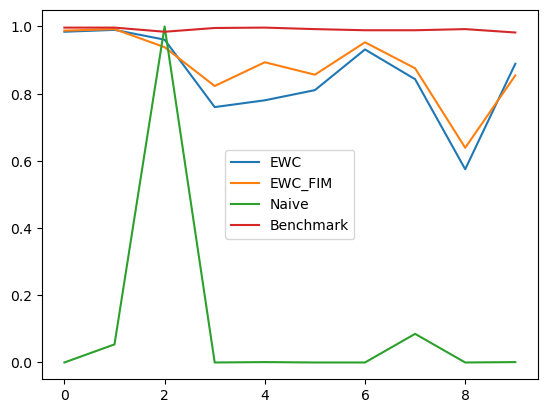

Computing clients information:   0%|          | 0/58 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.8675
Epoch 2/10, Loss: 14.3827
Epoch 3/10, Loss: 1.6575
Epoch 4/10, Loss: 3.4769
Epoch 5/10, Loss: 8.3941
Epoch 6/10, Loss: 6.3600
Epoch 7/10, Loss: 2.1681
Epoch 8/10, Loss: 0.7119
Epoch 9/10, Loss: 2.4292
Epoch 10/10, Loss: 4.3035


Computing clients information:   0%|          | 0/57 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7036
Epoch 2/10, Loss: 69.2968
Epoch 3/10, Loss: 5.1721
Epoch 4/10, Loss: 15.2779
Epoch 5/10, Loss: 40.1320
Epoch 6/10, Loss: 30.4460
Epoch 7/10, Loss: 9.2169
Epoch 8/10, Loss: 0.8025
Epoch 9/10, Loss: 8.9987
Epoch 10/10, Loss: 19.1938
cuda
Epoch 1/5, Loss: 3.4074
Epoch 2/5, Loss: 1.6761
Epoch 3/5, Loss: 1.0358
Epoch 4/5, Loss: 0.7375
Epoch 5/5, Loss: 0.5046


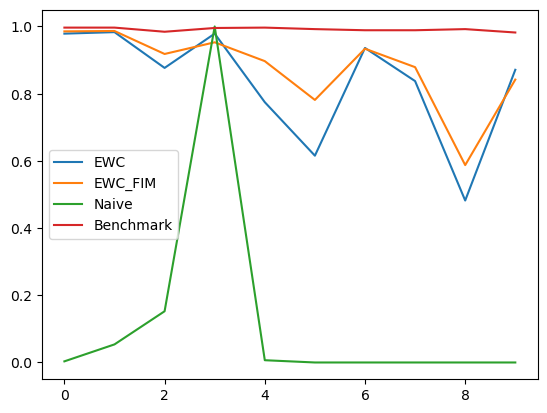

Computing clients information:   0%|          | 0/60 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6622
Epoch 2/10, Loss: 13.3966
Epoch 3/10, Loss: 1.4295
Epoch 4/10, Loss: 3.1544
Epoch 5/10, Loss: 7.8350
Epoch 6/10, Loss: 5.8690
Epoch 7/10, Loss: 1.9493
Epoch 8/10, Loss: 0.5657
Epoch 9/10, Loss: 2.1528
Epoch 10/10, Loss: 3.9294


Computing clients information:   0%|          | 0/59 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3956
Epoch 2/10, Loss: 72.7838
Epoch 3/10, Loss: 5.1250
Epoch 4/10, Loss: 15.7823
Epoch 5/10, Loss: 42.0622
Epoch 6/10, Loss: 31.9648
Epoch 7/10, Loss: 9.5309
Epoch 8/10, Loss: 0.4878
Epoch 9/10, Loss: 9.0573
Epoch 10/10, Loss: 19.9206
cuda
Epoch 1/5, Loss: 2.0059
Epoch 2/5, Loss: 1.3967
Epoch 3/5, Loss: 0.8278
Epoch 4/5, Loss: 0.3583
Epoch 5/5, Loss: 0.1011


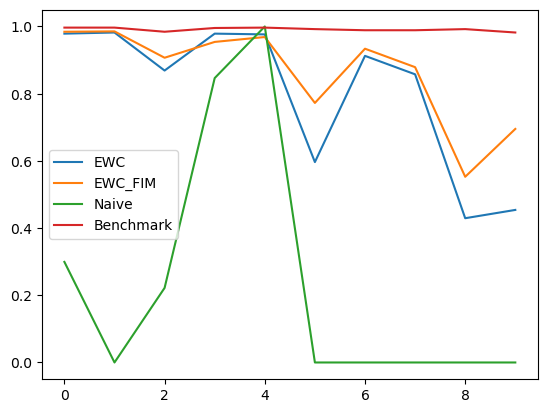

Computing clients information:   0%|          | 0/61 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.0358
Epoch 2/10, Loss: 13.8547
Epoch 3/10, Loss: 1.7204
Epoch 4/10, Loss: 3.2334
Epoch 5/10, Loss: 7.9201
Epoch 6/10, Loss: 5.9508
Epoch 7/10, Loss: 1.9332
Epoch 8/10, Loss: 0.6036
Epoch 9/10, Loss: 2.2754
Epoch 10/10, Loss: 4.0017


Computing clients information:   0%|          | 0/61 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5588
Epoch 2/10, Loss: 74.1527
Epoch 3/10, Loss: 5.3642
Epoch 4/10, Loss: 16.1994
Epoch 5/10, Loss: 42.8271
Epoch 6/10, Loss: 32.4358
Epoch 7/10, Loss: 9.6565
Epoch 8/10, Loss: 0.6829
Epoch 9/10, Loss: 9.5250
Epoch 10/10, Loss: 20.4011
cuda
Epoch 1/5, Loss: 4.2799
Epoch 2/5, Loss: 1.7024
Epoch 3/5, Loss: 0.6150
Epoch 4/5, Loss: 0.2150
Epoch 5/5, Loss: 0.0705


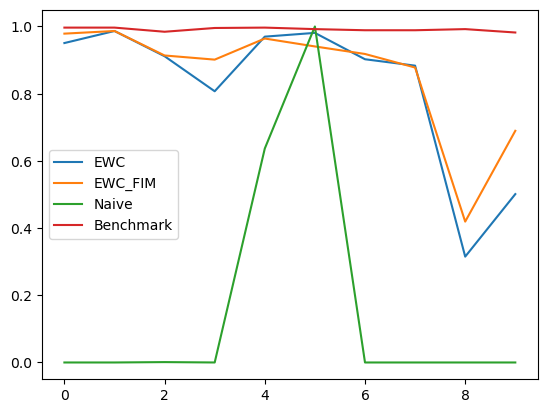

Computing clients information:   0%|          | 0/63 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2023
Epoch 2/10, Loss: 12.8172
Epoch 3/10, Loss: 1.0446
Epoch 4/10, Loss: 2.8554
Epoch 5/10, Loss: 7.4351
Epoch 6/10, Loss: 5.5057
Epoch 7/10, Loss: 1.6371
Epoch 8/10, Loss: 0.2850
Epoch 9/10, Loss: 1.8439
Epoch 10/10, Loss: 3.6030


Computing clients information:   0%|          | 0/62 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1338
Epoch 2/10, Loss: 75.9826
Epoch 3/10, Loss: 5.1216
Epoch 4/10, Loss: 16.3097
Epoch 5/10, Loss: 43.8266
Epoch 6/10, Loss: 33.1945
Epoch 7/10, Loss: 9.6916
Epoch 8/10, Loss: 0.2529
Epoch 9/10, Loss: 9.2342
Epoch 10/10, Loss: 20.6051
cuda
Epoch 1/5, Loss: 2.9555
Epoch 2/5, Loss: 1.5134
Epoch 3/5, Loss: 0.9189
Epoch 4/5, Loss: 0.5515
Epoch 5/5, Loss: 0.2771


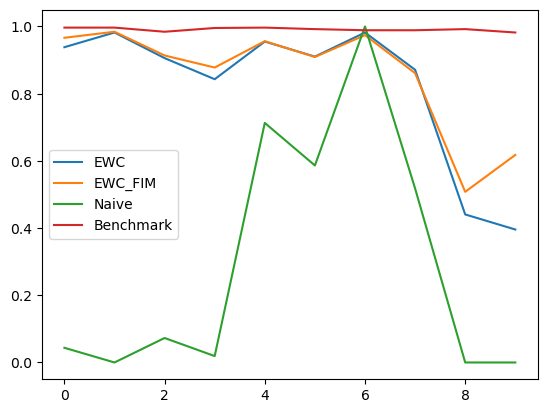

Computing clients information:   0%|          | 0/65 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4597
Epoch 2/10, Loss: 13.3261
Epoch 3/10, Loss: 1.2715
Epoch 4/10, Loss: 3.1040
Epoch 5/10, Loss: 7.7981
Epoch 6/10, Loss: 5.8697
Epoch 7/10, Loss: 1.8894
Epoch 8/10, Loss: 0.4527
Epoch 9/10, Loss: 2.0550
Epoch 10/10, Loss: 3.8785


Computing clients information:   0%|          | 0/64 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4685
Epoch 2/10, Loss: 74.0963
Epoch 3/10, Loss: 5.2733
Epoch 4/10, Loss: 16.1102
Epoch 5/10, Loss: 42.8156
Epoch 6/10, Loss: 32.5773
Epoch 7/10, Loss: 9.7546
Epoch 8/10, Loss: 0.5368
Epoch 9/10, Loss: 9.2594
Epoch 10/10, Loss: 20.3128
cuda
Epoch 1/5, Loss: 1.6192
Epoch 2/5, Loss: 0.7939
Epoch 3/5, Loss: 0.2705
Epoch 4/5, Loss: 0.0546
Epoch 5/5, Loss: 0.0073


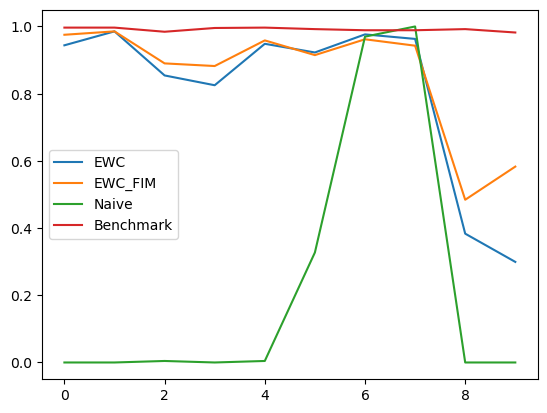

Computing clients information:   0%|          | 0/67 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.5294
Epoch 2/10, Loss: 13.1903
Epoch 3/10, Loss: 2.1093
Epoch 4/10, Loss: 3.1722
Epoch 5/10, Loss: 7.6287
Epoch 6/10, Loss: 5.9550
Epoch 7/10, Loss: 2.1764
Epoch 8/10, Loss: 0.8536
Epoch 9/10, Loss: 2.3792
Epoch 10/10, Loss: 3.9876


Computing clients information:   0%|          | 0/66 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2212
Epoch 2/10, Loss: 72.2753
Epoch 3/10, Loss: 5.8172
Epoch 4/10, Loss: 16.1661
Epoch 5/10, Loss: 41.8371
Epoch 6/10, Loss: 31.7018
Epoch 7/10, Loss: 9.7245
Epoch 8/10, Loss: 1.3218
Epoch 9/10, Loss: 10.0054
Epoch 10/10, Loss: 20.2660
cuda
Epoch 1/5, Loss: 5.7108
Epoch 2/5, Loss: 2.6433
Epoch 3/5, Loss: 1.3799
Epoch 4/5, Loss: 0.8314
Epoch 5/5, Loss: 0.4799


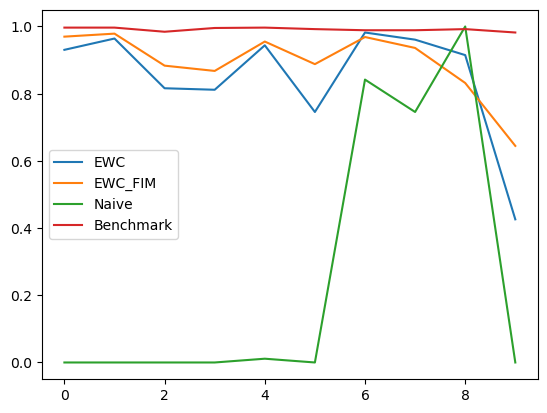

Computing clients information:   0%|          | 0/68 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.7213
Epoch 2/10, Loss: 13.4157
Epoch 3/10, Loss: 2.2651
Epoch 4/10, Loss: 3.5720
Epoch 5/10, Loss: 7.9065
Epoch 6/10, Loss: 6.1130
Epoch 7/10, Loss: 2.3688
Epoch 8/10, Loss: 1.0933
Epoch 9/10, Loss: 2.6219
Epoch 10/10, Loss: 4.2273


Computing clients information:   0%|          | 0/68 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.3573
Epoch 2/10, Loss: 74.1665
Epoch 3/10, Loss: 6.0806
Epoch 4/10, Loss: 16.7275
Epoch 5/10, Loss: 43.1121
Epoch 6/10, Loss: 32.8428
Epoch 7/10, Loss: 10.2968
Epoch 8/10, Loss: 1.4281
Epoch 9/10, Loss: 10.1852
Epoch 10/10, Loss: 20.9249
cuda
Epoch 1/5, Loss: 3.0569
Epoch 2/5, Loss: 1.9889
Epoch 3/5, Loss: 1.5354
Epoch 4/5, Loss: 1.2107
Epoch 5/5, Loss: 0.8701


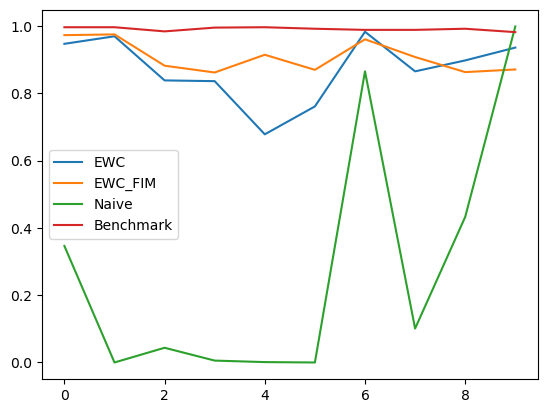

Computing clients information:   0%|          | 0/69 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1067
Epoch 2/10, Loss: 12.6173
Epoch 3/10, Loss: 0.9614
Epoch 4/10, Loss: 2.7933
Epoch 5/10, Loss: 7.3324
Epoch 6/10, Loss: 5.4231
Epoch 7/10, Loss: 1.5707
Epoch 8/10, Loss: 0.2100
Epoch 9/10, Loss: 1.7612
Epoch 10/10, Loss: 3.5279


Computing clients information:   0%|          | 0/69 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.0583
Epoch 2/10, Loss: 71.8168
Epoch 3/10, Loss: 4.8710
Epoch 4/10, Loss: 15.3401
Epoch 5/10, Loss: 41.4518
Epoch 6/10, Loss: 31.4680
Epoch 7/10, Loss: 9.2028
Epoch 8/10, Loss: 0.1573
Epoch 9/10, Loss: 8.6078
Epoch 10/10, Loss: 19.4378
cuda
Epoch 1/5, Loss: 1.2776
Epoch 2/5, Loss: 0.4833
Epoch 3/5, Loss: 0.1193
Epoch 4/5, Loss: 0.0209
Epoch 5/5, Loss: 0.0028


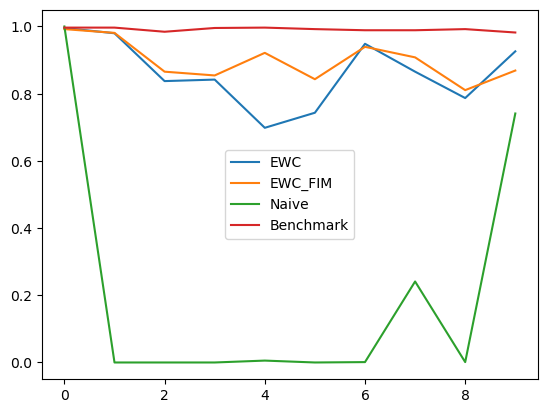

Computing clients information:   0%|          | 0/71 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.0843
Epoch 2/10, Loss: 9.8537
Epoch 3/10, Loss: 0.8218
Epoch 4/10, Loss: 2.1988
Epoch 5/10, Loss: 5.8249
Epoch 6/10, Loss: 4.3488
Epoch 7/10, Loss: 1.3097
Epoch 8/10, Loss: 0.1919
Epoch 9/10, Loss: 1.3763
Epoch 10/10, Loss: 2.7922


Computing clients information:   0%|          | 0/71 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.0469
Epoch 2/10, Loss: 73.1590
Epoch 3/10, Loss: 4.8425
Epoch 4/10, Loss: 15.5670
Epoch 5/10, Loss: 42.1835
Epoch 6/10, Loss: 32.1259
Epoch 7/10, Loss: 9.4563
Epoch 8/10, Loss: 0.1109
Epoch 9/10, Loss: 8.6274
Epoch 10/10, Loss: 19.7229
cuda
Epoch 1/5, Loss: 3.8979
Epoch 2/5, Loss: 1.6615
Epoch 3/5, Loss: 0.5660
Epoch 4/5, Loss: 0.1632
Epoch 5/5, Loss: 0.0438


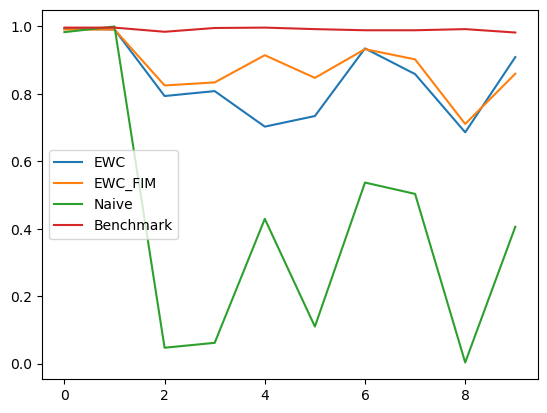

Computing clients information:   0%|          | 0/73 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.8881
Epoch 2/10, Loss: 14.3857
Epoch 3/10, Loss: 1.6861
Epoch 4/10, Loss: 3.5264
Epoch 5/10, Loss: 8.4353
Epoch 6/10, Loss: 6.4054
Epoch 7/10, Loss: 2.1964
Epoch 8/10, Loss: 0.7304
Epoch 9/10, Loss: 2.4520
Epoch 10/10, Loss: 4.3238


Computing clients information:   0%|          | 0/73 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.8338
Epoch 2/10, Loss: 79.6712
Epoch 3/10, Loss: 5.9561
Epoch 4/10, Loss: 17.5380
Epoch 5/10, Loss: 46.1381
Epoch 6/10, Loss: 35.1441
Epoch 7/10, Loss: 10.7115
Epoch 8/10, Loss: 0.8900
Epoch 9/10, Loss: 10.2560
Epoch 10/10, Loss: 22.0569
cuda
Epoch 1/5, Loss: 2.8612
Epoch 2/5, Loss: 0.9215
Epoch 3/5, Loss: 0.2378
Epoch 4/5, Loss: 0.0504
Epoch 5/5, Loss: 0.0102


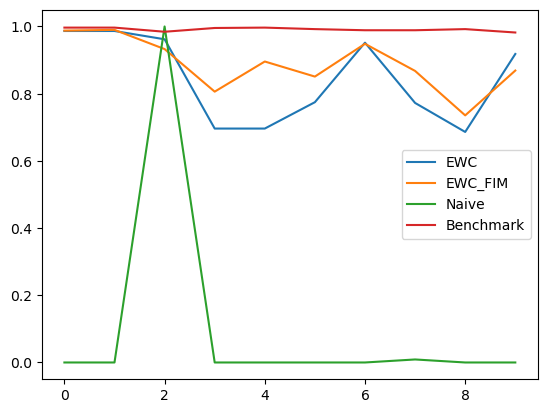

Computing clients information:   0%|          | 0/75 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.3467
Epoch 2/10, Loss: 13.6417
Epoch 3/10, Loss: 1.9173
Epoch 4/10, Loss: 3.3764
Epoch 5/10, Loss: 7.9029
Epoch 6/10, Loss: 6.0106
Epoch 7/10, Loss: 2.1271
Epoch 8/10, Loss: 0.8271
Epoch 9/10, Loss: 2.4269
Epoch 10/10, Loss: 4.0822


Computing clients information:   0%|          | 0/74 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.9183
Epoch 2/10, Loss: 75.5100
Epoch 3/10, Loss: 5.7549
Epoch 4/10, Loss: 16.7040
Epoch 5/10, Loss: 43.7141
Epoch 6/10, Loss: 33.2312
Epoch 7/10, Loss: 10.1240
Epoch 8/10, Loss: 0.9920
Epoch 9/10, Loss: 9.9514
Epoch 10/10, Loss: 20.9879
cuda
Epoch 1/5, Loss: 4.7194
Epoch 2/5, Loss: 1.9013
Epoch 3/5, Loss: 0.8058
Epoch 4/5, Loss: 0.4390
Epoch 5/5, Loss: 0.2669


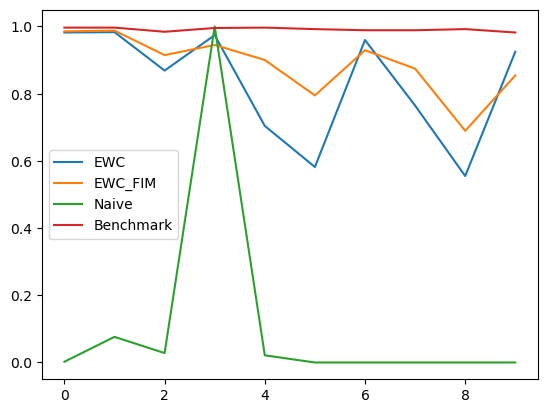

Computing clients information:   0%|          | 0/76 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.8487
Epoch 2/10, Loss: 12.4509
Epoch 3/10, Loss: 1.4947
Epoch 4/10, Loss: 2.9326
Epoch 5/10, Loss: 7.1940
Epoch 6/10, Loss: 5.4284
Epoch 7/10, Loss: 1.7951
Epoch 8/10, Loss: 0.5678
Epoch 9/10, Loss: 2.0474
Epoch 10/10, Loss: 3.6318


Computing clients information:   0%|          | 0/76 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4013
Epoch 2/10, Loss: 80.0484
Epoch 3/10, Loss: 5.6241
Epoch 4/10, Loss: 17.3400
Epoch 5/10, Loss: 46.2242
Epoch 6/10, Loss: 35.1081
Epoch 7/10, Loss: 10.4183
Epoch 8/10, Loss: 0.5085
Epoch 9/10, Loss: 9.9678
Epoch 10/10, Loss: 21.8893
cuda
Epoch 1/5, Loss: 1.8490
Epoch 2/5, Loss: 1.0892
Epoch 3/5, Loss: 0.5090
Epoch 4/5, Loss: 0.1571
Epoch 5/5, Loss: 0.0312


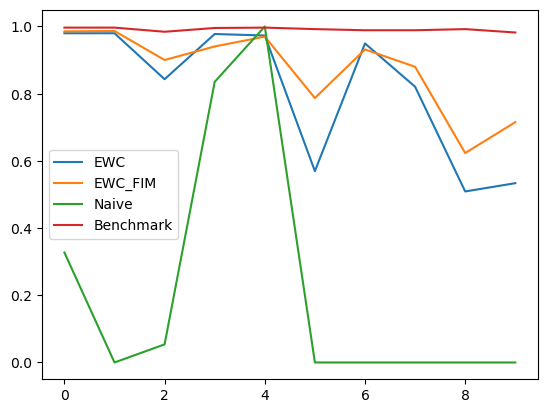

Computing clients information:   0%|          | 0/78 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.3537
Epoch 2/10, Loss: 13.6704
Epoch 3/10, Loss: 1.9354
Epoch 4/10, Loss: 3.4066
Epoch 5/10, Loss: 7.9334
Epoch 6/10, Loss: 6.0493
Epoch 7/10, Loss: 2.1519
Epoch 8/10, Loss: 0.8639
Epoch 9/10, Loss: 2.4719
Epoch 10/10, Loss: 4.1268


Computing clients information:   0%|          | 0/78 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7067
Epoch 2/10, Loss: 82.4025
Epoch 3/10, Loss: 6.0352
Epoch 4/10, Loss: 18.0559
Epoch 5/10, Loss: 47.6418
Epoch 6/10, Loss: 36.1942
Epoch 7/10, Loss: 10.8807
Epoch 8/10, Loss: 0.8026
Epoch 9/10, Loss: 10.5784
Epoch 10/10, Loss: 22.7334
cuda
Epoch 1/5, Loss: 4.0176
Epoch 2/5, Loss: 1.6066
Epoch 3/5, Loss: 0.6140
Epoch 4/5, Loss: 0.2367
Epoch 5/5, Loss: 0.0863


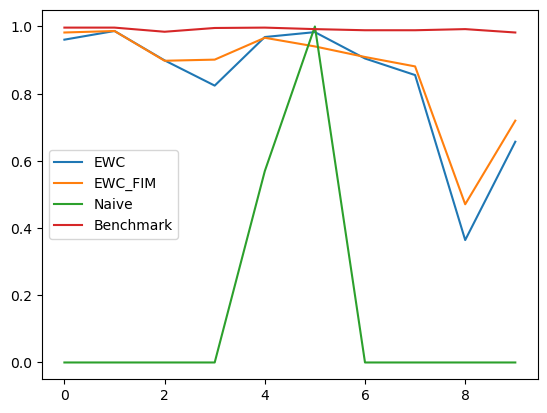

Computing clients information:   0%|          | 0/80 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1966
Epoch 2/10, Loss: 12.7386
Epoch 3/10, Loss: 1.1028
Epoch 4/10, Loss: 2.8266
Epoch 5/10, Loss: 7.4505
Epoch 6/10, Loss: 5.5601
Epoch 7/10, Loss: 1.6856
Epoch 8/10, Loss: 0.2621
Epoch 9/10, Loss: 1.8048
Epoch 10/10, Loss: 3.6032


Computing clients information:   0%|          | 0/80 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1486
Epoch 2/10, Loss: 84.3373
Epoch 3/10, Loss: 5.6608
Epoch 4/10, Loss: 18.0476
Epoch 5/10, Loss: 48.6166
Epoch 6/10, Loss: 36.9209
Epoch 7/10, Loss: 10.8300
Epoch 8/10, Loss: 0.2413
Epoch 9/10, Loss: 10.1553
Epoch 10/10, Loss: 22.8318
cuda
Epoch 1/5, Loss: 2.5547
Epoch 2/5, Loss: 1.1671
Epoch 3/5, Loss: 0.5927
Epoch 4/5, Loss: 0.2753
Epoch 5/5, Loss: 0.1028


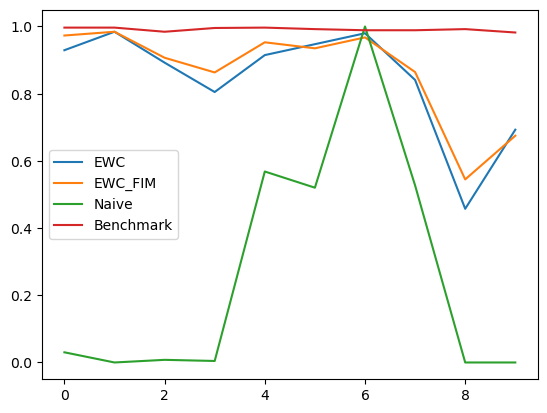

Computing clients information:   0%|          | 0/81 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4254
Epoch 2/10, Loss: 12.3026
Epoch 3/10, Loss: 1.1855
Epoch 4/10, Loss: 2.8372
Epoch 5/10, Loss: 7.2098
Epoch 6/10, Loss: 5.4320
Epoch 7/10, Loss: 1.7528
Epoch 8/10, Loss: 0.4232
Epoch 9/10, Loss: 1.8816
Epoch 10/10, Loss: 3.5603


Computing clients information:   0%|          | 0/81 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3040
Epoch 2/10, Loss: 83.8682
Epoch 3/10, Loss: 5.7673
Epoch 4/10, Loss: 18.0511
Epoch 5/10, Loss: 48.3980
Epoch 6/10, Loss: 36.8437
Epoch 7/10, Loss: 10.9400
Epoch 8/10, Loss: 0.3771
Epoch 9/10, Loss: 10.2085
Epoch 10/10, Loss: 22.8156
cuda
Epoch 1/5, Loss: 1.5110
Epoch 2/5, Loss: 0.5914
Epoch 3/5, Loss: 0.1632
Epoch 4/5, Loss: 0.0299
Epoch 5/5, Loss: 0.0042


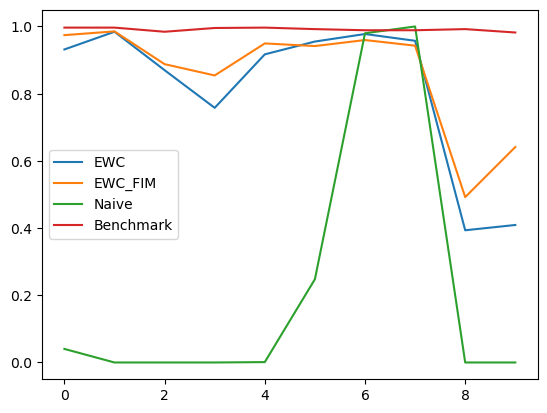

Computing clients information:   0%|          | 0/83 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.7057
Epoch 2/10, Loss: 13.4587
Epoch 3/10, Loss: 2.2673
Epoch 4/10, Loss: 3.4054
Epoch 5/10, Loss: 7.8719
Epoch 6/10, Loss: 6.1849
Epoch 7/10, Loss: 2.3410
Epoch 8/10, Loss: 0.9707
Epoch 9/10, Loss: 2.5157
Epoch 10/10, Loss: 4.1666


Computing clients information:   0%|          | 0/83 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.5149
Epoch 2/10, Loss: 82.9716
Epoch 3/10, Loss: 6.7486
Epoch 4/10, Loss: 18.6319
Epoch 5/10, Loss: 48.1138
Epoch 6/10, Loss: 36.6590
Epoch 7/10, Loss: 11.4213
Epoch 8/10, Loss: 1.5319
Epoch 9/10, Loss: 11.4052
Epoch 10/10, Loss: 23.3576
cuda
Epoch 1/5, Loss: 4.7502
Epoch 2/5, Loss: 2.1727
Epoch 3/5, Loss: 1.0202
Epoch 4/5, Loss: 0.4766
Epoch 5/5, Loss: 0.1928


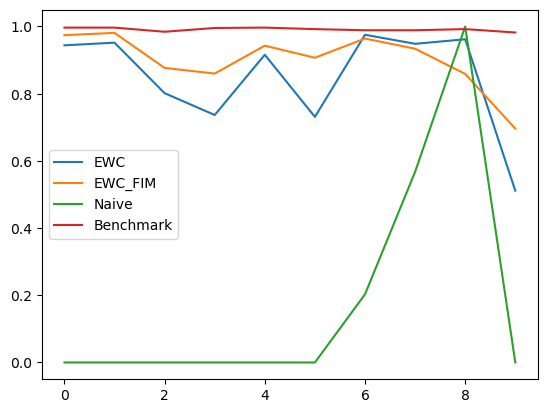

Computing clients information:   0%|          | 0/85 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.5357
Epoch 2/10, Loss: 12.4107
Epoch 3/10, Loss: 2.0511
Epoch 4/10, Loss: 3.2722
Epoch 5/10, Loss: 7.3058
Epoch 6/10, Loss: 5.6582
Epoch 7/10, Loss: 2.1621
Epoch 8/10, Loss: 0.9623
Epoch 9/10, Loss: 2.3798
Epoch 10/10, Loss: 3.8835


Computing clients information:   0%|          | 0/85 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2065
Epoch 2/10, Loss: 86.9616
Epoch 3/10, Loss: 6.7797
Epoch 4/10, Loss: 19.3602
Epoch 5/10, Loss: 50.4447
Epoch 6/10, Loss: 38.4560
Epoch 7/10, Loss: 11.8879
Epoch 8/10, Loss: 1.2838
Epoch 9/10, Loss: 11.5154
Epoch 10/10, Loss: 24.2794
cuda
Epoch 1/5, Loss: 3.5365
Epoch 2/5, Loss: 1.8705
Epoch 3/5, Loss: 1.1843
Epoch 4/5, Loss: 0.8028
Epoch 5/5, Loss: 0.5009


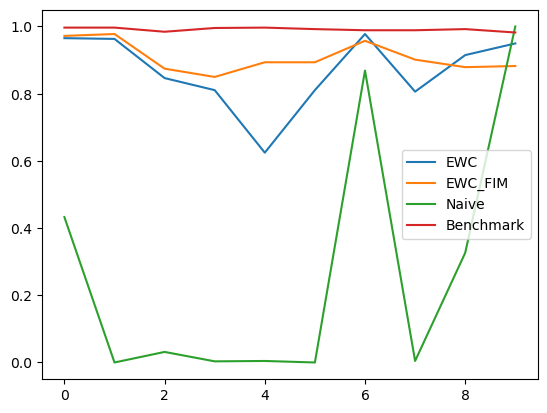

Computing clients information:   0%|          | 0/87 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1728
Epoch 2/10, Loss: 12.2385
Epoch 3/10, Loss: 0.9779
Epoch 4/10, Loss: 2.7288
Epoch 5/10, Loss: 7.1397
Epoch 6/10, Loss: 5.3244
Epoch 7/10, Loss: 1.6002
Epoch 8/10, Loss: 0.2622
Epoch 9/10, Loss: 1.7421
Epoch 10/10, Loss: 3.4520


Computing clients information:   0%|          | 0/86 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1203
Epoch 2/10, Loss: 85.3382
Epoch 3/10, Loss: 5.6953
Epoch 4/10, Loss: 18.2238
Epoch 5/10, Loss: 49.2029
Epoch 6/10, Loss: 37.3474
Epoch 7/10, Loss: 10.9603
Epoch 8/10, Loss: 0.2187
Epoch 9/10, Loss: 10.2141
Epoch 10/10, Loss: 23.0693
cuda
Epoch 1/5, Loss: 1.1199
Epoch 2/5, Loss: 0.3454
Epoch 3/5, Loss: 0.0737
Epoch 4/5, Loss: 0.0116
Epoch 5/5, Loss: 0.0016


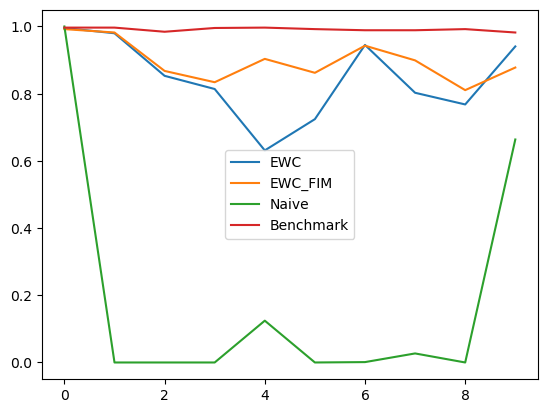

Computing clients information:   0%|          | 0/89 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2404
Epoch 2/10, Loss: 11.4248
Epoch 3/10, Loss: 1.0454
Epoch 4/10, Loss: 2.5972
Epoch 5/10, Loss: 6.7605
Epoch 6/10, Loss: 5.1112
Epoch 7/10, Loss: 1.6172
Epoch 8/10, Loss: 0.3367
Epoch 9/10, Loss: 1.6871
Epoch 10/10, Loss: 3.2894


Computing clients information:   0%|          | 0/88 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1619
Epoch 2/10, Loss: 87.3243
Epoch 3/10, Loss: 5.8727
Epoch 4/10, Loss: 18.6468
Epoch 5/10, Loss: 50.4047
Epoch 6/10, Loss: 38.4046
Epoch 7/10, Loss: 11.4044
Epoch 8/10, Loss: 0.2509
Epoch 9/10, Loss: 10.3887
Epoch 10/10, Loss: 23.6111
cuda
Epoch 1/5, Loss: 3.2819
Epoch 2/5, Loss: 1.1667
Epoch 3/5, Loss: 0.3121
Epoch 4/5, Loss: 0.0767
Epoch 5/5, Loss: 0.0196


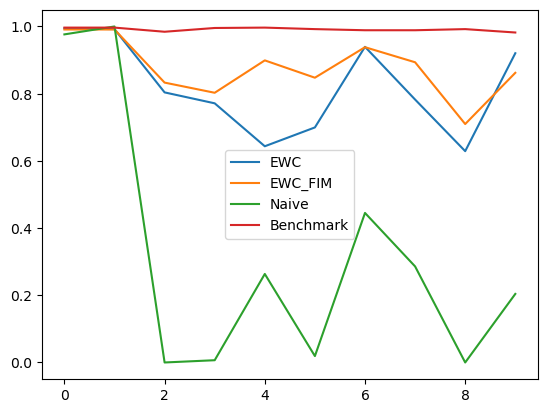

Computing clients information:   0%|          | 0/90 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7329
Epoch 2/10, Loss: 13.5672
Epoch 3/10, Loss: 1.5008
Epoch 4/10, Loss: 3.2047
Epoch 5/10, Loss: 7.8937
Epoch 6/10, Loss: 5.9680
Epoch 7/10, Loss: 1.9807
Epoch 8/10, Loss: 0.5745
Epoch 9/10, Loss: 2.1988
Epoch 10/10, Loss: 3.9849


Computing clients information:   0%|          | 0/90 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6533
Epoch 2/10, Loss: 90.7223
Epoch 3/10, Loss: 6.5260
Epoch 4/10, Loss: 19.7619
Epoch 5/10, Loss: 52.4321
Epoch 6/10, Loss: 39.8881
Epoch 7/10, Loss: 11.9788
Epoch 8/10, Loss: 0.7407
Epoch 9/10, Loss: 11.4218
Epoch 10/10, Loss: 24.9107
cuda
Epoch 1/5, Loss: 4.3883
Epoch 2/5, Loss: 1.6371
Epoch 3/5, Loss: 0.4746
Epoch 4/5, Loss: 0.1174
Epoch 5/5, Loss: 0.0266


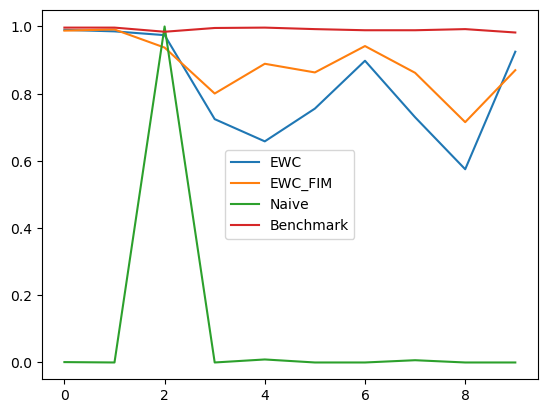

Computing clients information:   0%|          | 0/92 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7927
Epoch 2/10, Loss: 12.8734
Epoch 3/10, Loss: 1.4762
Epoch 4/10, Loss: 3.0436
Epoch 5/10, Loss: 7.4847
Epoch 6/10, Loss: 5.6246
Epoch 7/10, Loss: 1.8682
Epoch 8/10, Loss: 0.5594
Epoch 9/10, Loss: 2.0922
Epoch 10/10, Loss: 3.7598


Computing clients information:   0%|          | 0/92 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5838
Epoch 2/10, Loss: 91.0635
Epoch 3/10, Loss: 6.4830
Epoch 4/10, Loss: 19.7809
Epoch 5/10, Loss: 52.5994
Epoch 6/10, Loss: 40.0120
Epoch 7/10, Loss: 11.9729
Epoch 8/10, Loss: 0.6658
Epoch 9/10, Loss: 11.3948
Epoch 10/10, Loss: 24.9593
cuda
Epoch 1/5, Loss: 3.9083
Epoch 2/5, Loss: 1.4536
Epoch 3/5, Loss: 0.5617
Epoch 4/5, Loss: 0.2548
Epoch 5/5, Loss: 0.1213


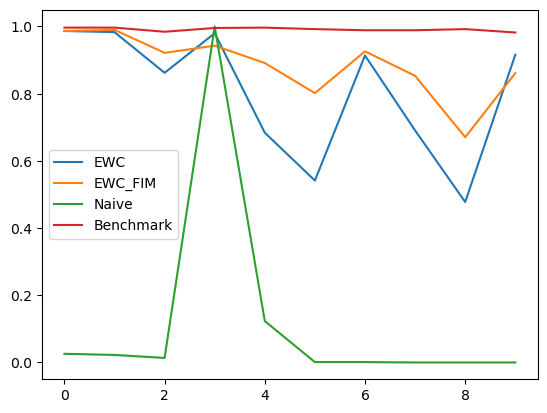

Computing clients information:   0%|          | 0/94 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2698
Epoch 2/10, Loss: 13.3645
Epoch 3/10, Loss: 1.9043
Epoch 4/10, Loss: 3.3574
Epoch 5/10, Loss: 7.8307
Epoch 6/10, Loss: 5.9846
Epoch 7/10, Loss: 2.1557
Epoch 8/10, Loss: 0.8281
Epoch 9/10, Loss: 2.3731
Epoch 10/10, Loss: 4.0427


Computing clients information:   0%|          | 0/93 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7394
Epoch 2/10, Loss: 95.2062
Epoch 3/10, Loss: 6.9406
Epoch 4/10, Loss: 20.7869
Epoch 5/10, Loss: 55.0675
Epoch 6/10, Loss: 41.9286
Epoch 7/10, Loss: 12.6429
Epoch 8/10, Loss: 0.8363
Epoch 9/10, Loss: 12.0387
Epoch 10/10, Loss: 26.1993
cuda
Epoch 1/5, Loss: 1.7474
Epoch 2/5, Loss: 0.8983
Epoch 3/5, Loss: 0.3620
Epoch 4/5, Loss: 0.0982
Epoch 5/5, Loss: 0.0195


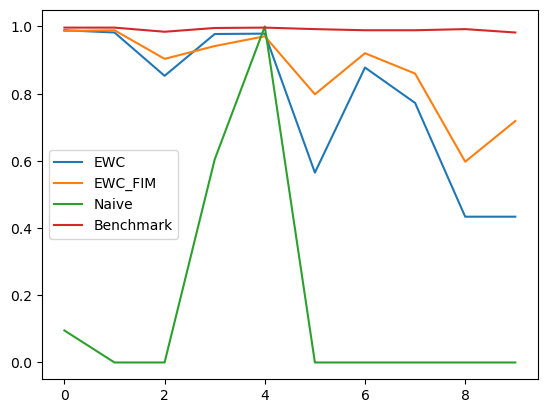

Computing clients information:   0%|          | 0/95 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2479
Epoch 2/10, Loss: 13.0248
Epoch 3/10, Loss: 1.7879
Epoch 4/10, Loss: 3.2051
Epoch 5/10, Loss: 7.5204
Epoch 6/10, Loss: 5.7337
Epoch 7/10, Loss: 1.9784
Epoch 8/10, Loss: 0.7049
Epoch 9/10, Loss: 2.2394
Epoch 10/10, Loss: 3.8429


Computing clients information:   0%|          | 0/95 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6571
Epoch 2/10, Loss: 96.0309
Epoch 3/10, Loss: 6.8700
Epoch 4/10, Loss: 20.8730
Epoch 5/10, Loss: 55.4594
Epoch 6/10, Loss: 42.2268
Epoch 7/10, Loss: 12.6692
Epoch 8/10, Loss: 0.7296
Epoch 9/10, Loss: 12.0437
Epoch 10/10, Loss: 26.3391
cuda
Epoch 1/5, Loss: 4.5436
Epoch 2/5, Loss: 1.8889
Epoch 3/5, Loss: 0.7007
Epoch 4/5, Loss: 0.2576
Epoch 5/5, Loss: 0.0916


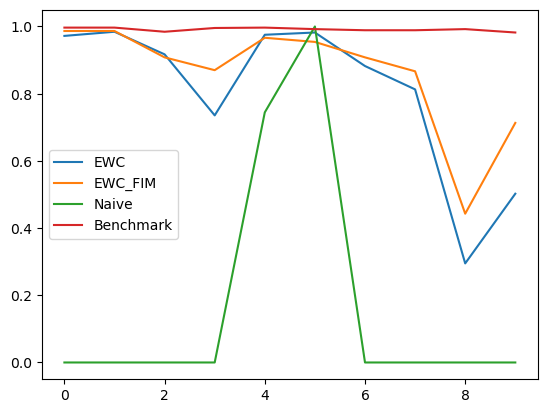

Computing clients information:   0%|          | 0/97 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6447
Epoch 2/10, Loss: 12.3063
Epoch 3/10, Loss: 1.3769
Epoch 4/10, Loss: 2.9223
Epoch 5/10, Loss: 7.2110
Epoch 6/10, Loss: 5.4926
Epoch 7/10, Loss: 1.8331
Epoch 8/10, Loss: 0.5295
Epoch 9/10, Loss: 1.9987
Epoch 10/10, Loss: 3.6322


Computing clients information:   0%|          | 0/97 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5254
Epoch 2/10, Loss: 96.4184
Epoch 3/10, Loss: 6.7803
Epoch 4/10, Loss: 20.8539
Epoch 5/10, Loss: 55.7031
Epoch 6/10, Loss: 42.4762
Epoch 7/10, Loss: 12.7379
Epoch 8/10, Loss: 0.6326
Epoch 9/10, Loss: 11.9046
Epoch 10/10, Loss: 26.3452
cuda
Epoch 1/5, Loss: 2.5439
Epoch 2/5, Loss: 1.2701
Epoch 3/5, Loss: 0.6754
Epoch 4/5, Loss: 0.3203
Epoch 5/5, Loss: 0.1239


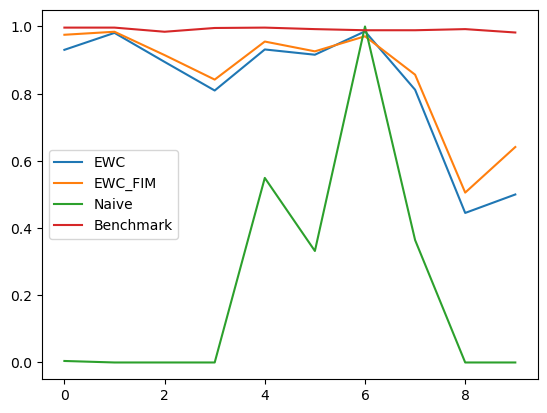

Computing clients information:   0%|          | 0/99 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5708
Epoch 2/10, Loss: 12.1626
Epoch 3/10, Loss: 1.2882
Epoch 4/10, Loss: 2.8455
Epoch 5/10, Loss: 7.0918
Epoch 6/10, Loss: 5.3948
Epoch 7/10, Loss: 1.7551
Epoch 8/10, Loss: 0.4890
Epoch 9/10, Loss: 1.9439
Epoch 10/10, Loss: 3.5524


Computing clients information:   0%|          | 0/98 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3589
Epoch 2/10, Loss: 93.9596
Epoch 3/10, Loss: 6.4802
Epoch 4/10, Loss: 20.2374
Epoch 5/10, Loss: 54.2500
Epoch 6/10, Loss: 41.2634
Epoch 7/10, Loss: 12.2725
Epoch 8/10, Loss: 0.4723
Epoch 9/10, Loss: 11.4759
Epoch 10/10, Loss: 25.5708
cuda
Epoch 1/5, Loss: 1.9593
Epoch 2/5, Loss: 0.8459
Epoch 3/5, Loss: 0.2630
Epoch 4/5, Loss: 0.0594
Epoch 5/5, Loss: 0.0115


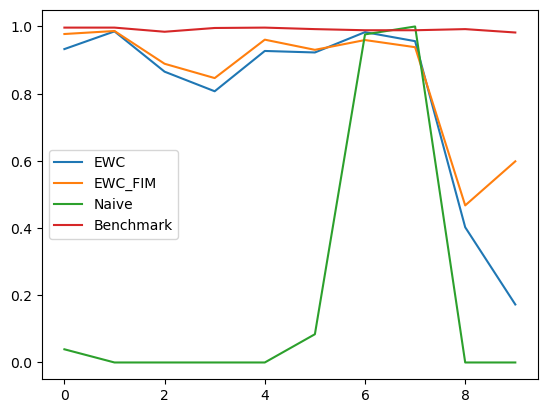

Computing clients information:   0%|          | 0/101 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.4769
Epoch 2/10, Loss: 12.6638
Epoch 3/10, Loss: 2.0707
Epoch 4/10, Loss: 3.2435
Epoch 5/10, Loss: 7.4664
Epoch 6/10, Loss: 5.8454
Epoch 7/10, Loss: 2.2127
Epoch 8/10, Loss: 0.9094
Epoch 9/10, Loss: 2.3734
Epoch 10/10, Loss: 3.9478


Computing clients information:   0%|          | 0/100 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.3800
Epoch 2/10, Loss: 92.7801
Epoch 3/10, Loss: 7.2964
Epoch 4/10, Loss: 20.6837
Epoch 5/10, Loss: 53.7959
Epoch 6/10, Loss: 41.0406
Epoch 7/10, Loss: 12.7085
Epoch 8/10, Loss: 1.4351
Epoch 9/10, Loss: 12.4016
Epoch 10/10, Loss: 25.9667
cuda
Epoch 1/5, Loss: 3.9909
Epoch 2/5, Loss: 1.9486
Epoch 3/5, Loss: 1.0492
Epoch 4/5, Loss: 0.5483
Epoch 5/5, Loss: 0.2341


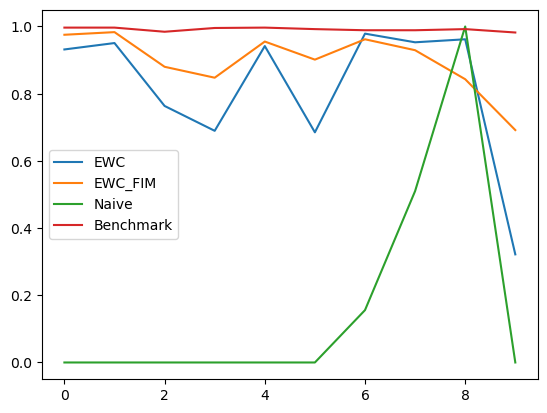

Computing clients information:   0%|          | 0/102 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.6644
Epoch 2/10, Loss: 12.0541
Epoch 3/10, Loss: 2.0822
Epoch 4/10, Loss: 3.2499
Epoch 5/10, Loss: 7.1082
Epoch 6/10, Loss: 5.5009
Epoch 7/10, Loss: 2.1485
Epoch 8/10, Loss: 0.9855
Epoch 9/10, Loss: 2.3355
Epoch 10/10, Loss: 3.7718


Computing clients information:   0%|          | 0/102 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.1046
Epoch 2/10, Loss: 97.1603
Epoch 3/10, Loss: 7.3988
Epoch 4/10, Loss: 21.4349
Epoch 5/10, Loss: 56.2956
Epoch 6/10, Loss: 42.9774
Epoch 7/10, Loss: 13.1857
Epoch 8/10, Loss: 1.1677
Epoch 9/10, Loss: 12.5766
Epoch 10/10, Loss: 26.9625
cuda
Epoch 1/5, Loss: 3.1844
Epoch 2/5, Loss: 1.6422
Epoch 3/5, Loss: 0.9798
Epoch 4/5, Loss: 0.5984
Epoch 5/5, Loss: 0.3226


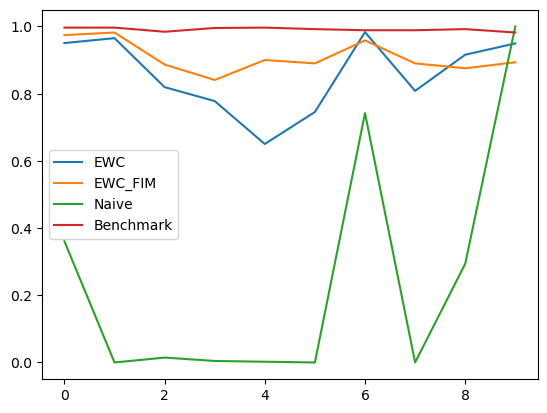

Computing clients information:   0%|          | 0/104 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2164
Epoch 2/10, Loss: 11.3922
Epoch 3/10, Loss: 0.9534
Epoch 4/10, Loss: 2.5495
Epoch 5/10, Loss: 6.6244
Epoch 6/10, Loss: 4.9510
Epoch 7/10, Loss: 1.5064
Epoch 8/10, Loss: 0.2528
Epoch 9/10, Loss: 1.6279
Epoch 10/10, Loss: 3.2194


Computing clients information:   0%|          | 0/104 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1460
Epoch 2/10, Loss: 96.6480
Epoch 3/10, Loss: 6.5630
Epoch 4/10, Loss: 20.6346
Epoch 5/10, Loss: 55.7857
Epoch 6/10, Loss: 42.5038
Epoch 7/10, Loss: 12.5483
Epoch 8/10, Loss: 0.2622
Epoch 9/10, Loss: 11.5426
Epoch 10/10, Loss: 26.1563
cuda
Epoch 1/5, Loss: 1.2572
Epoch 2/5, Loss: 0.3768
Epoch 3/5, Loss: 0.0923
Epoch 4/5, Loss: 0.0195
Epoch 5/5, Loss: 0.0038


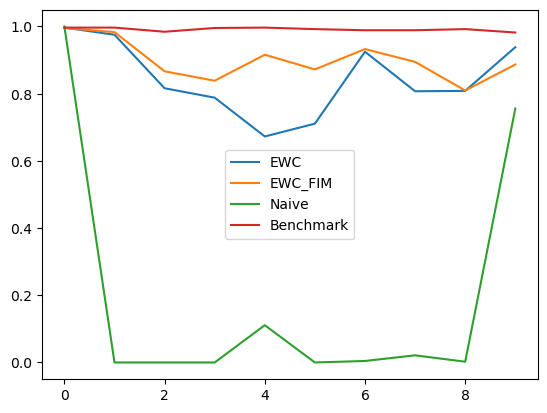

Computing clients information:   0%|          | 0/106 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2000
Epoch 2/10, Loss: 8.8346
Epoch 3/10, Loss: 0.8669
Epoch 4/10, Loss: 2.0157
Epoch 5/10, Loss: 5.2248
Epoch 6/10, Loss: 3.9687
Epoch 7/10, Loss: 1.2509
Epoch 8/10, Loss: 0.2402
Epoch 9/10, Loss: 1.3067
Epoch 10/10, Loss: 2.5604


Computing clients information:   0%|          | 0/105 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.0981
Epoch 2/10, Loss: 100.4356
Epoch 3/10, Loss: 6.6754
Epoch 4/10, Loss: 21.3678
Epoch 5/10, Loss: 57.8797
Epoch 6/10, Loss: 44.1990
Epoch 7/10, Loss: 13.0646
Epoch 8/10, Loss: 0.1636
Epoch 9/10, Loss: 11.8180
Epoch 10/10, Loss: 27.0749
cuda
Epoch 1/5, Loss: 3.2533
Epoch 2/5, Loss: 1.2862
Epoch 3/5, Loss: 0.3586
Epoch 4/5, Loss: 0.0790
Epoch 5/5, Loss: 0.0168


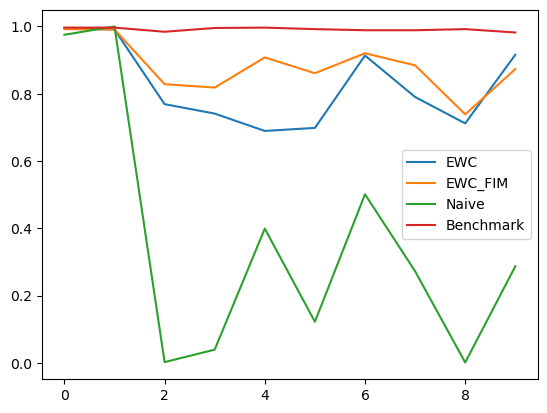

Computing clients information:   0%|          | 0/108 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7912
Epoch 2/10, Loss: 13.0756
Epoch 3/10, Loss: 1.5176
Epoch 4/10, Loss: 3.1280
Epoch 5/10, Loss: 7.6249
Epoch 6/10, Loss: 5.7869
Epoch 7/10, Loss: 1.9581
Epoch 8/10, Loss: 0.6028
Epoch 9/10, Loss: 2.1525
Epoch 10/10, Loss: 3.8681


Computing clients information:   0%|          | 0/107 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6074
Epoch 2/10, Loss: 107.4124
Epoch 3/10, Loss: 7.5831
Epoch 4/10, Loss: 23.2755
Epoch 5/10, Loss: 62.0373
Epoch 6/10, Loss: 47.2341
Epoch 7/10, Loss: 14.1387
Epoch 8/10, Loss: 0.7106
Epoch 9/10, Loss: 13.3049
Epoch 10/10, Loss: 29.3663
cuda
Epoch 1/5, Loss: 4.0764
Epoch 2/5, Loss: 1.4612
Epoch 3/5, Loss: 0.3680
Epoch 4/5, Loss: 0.0782
Epoch 5/5, Loss: 0.0162


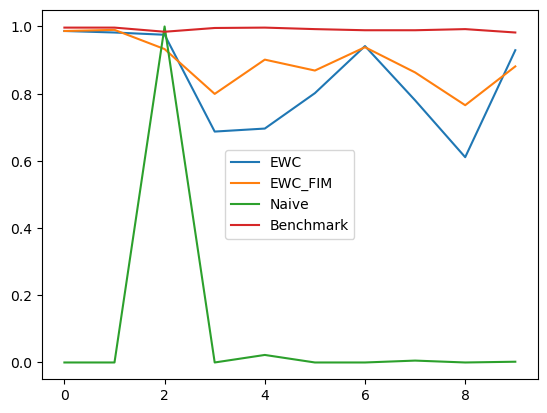

Computing clients information:   0%|          | 0/109 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2766
Epoch 2/10, Loss: 12.8186
Epoch 3/10, Loss: 1.8225
Epoch 4/10, Loss: 3.2092
Epoch 5/10, Loss: 7.4723
Epoch 6/10, Loss: 5.7075
Epoch 7/10, Loss: 2.0354
Epoch 8/10, Loss: 0.7583
Epoch 9/10, Loss: 2.2374
Epoch 10/10, Loss: 3.8261


Computing clients information:   0%|          | 0/109 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.8788
Epoch 2/10, Loss: 104.1640
Epoch 3/10, Loss: 7.5998
Epoch 4/10, Loss: 22.7448
Epoch 5/10, Loss: 60.2230
Epoch 6/10, Loss: 45.9184
Epoch 7/10, Loss: 13.9041
Epoch 8/10, Loss: 0.9432
Epoch 9/10, Loss: 13.1681
Epoch 10/10, Loss: 28.6682
cuda
Epoch 1/5, Loss: 3.9779
Epoch 2/5, Loss: 1.5368
Epoch 3/5, Loss: 0.6313
Epoch 4/5, Loss: 0.3123
Epoch 5/5, Loss: 0.1596


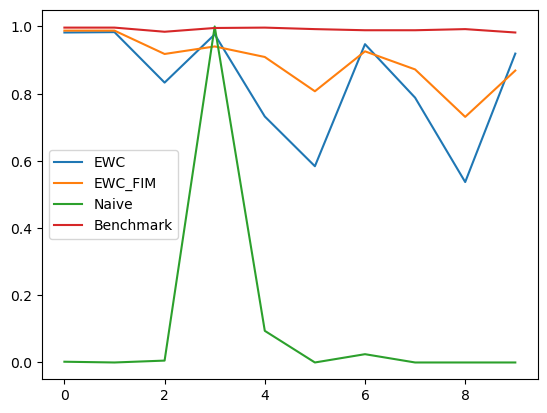

Computing clients information:   0%|          | 0/111 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7917
Epoch 2/10, Loss: 11.4942
Epoch 3/10, Loss: 1.4075
Epoch 4/10, Loss: 2.7326
Epoch 5/10, Loss: 6.6835
Epoch 6/10, Loss: 5.0812
Epoch 7/10, Loss: 1.7208
Epoch 8/10, Loss: 0.5172
Epoch 9/10, Loss: 1.8687
Epoch 10/10, Loss: 3.3787


Computing clients information:   0%|          | 0/110 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3587
Epoch 2/10, Loss: 108.7318
Epoch 3/10, Loss: 7.4484
Epoch 4/10, Loss: 23.3620
Epoch 5/10, Loss: 62.7160
Epoch 6/10, Loss: 47.7871
Epoch 7/10, Loss: 14.1776
Epoch 8/10, Loss: 0.4559
Epoch 9/10, Loss: 13.1847
Epoch 10/10, Loss: 29.5386
cuda
Epoch 1/5, Loss: 1.6129
Epoch 2/5, Loss: 0.7782
Epoch 3/5, Loss: 0.2803
Epoch 4/5, Loss: 0.0681
Epoch 5/5, Loss: 0.0134


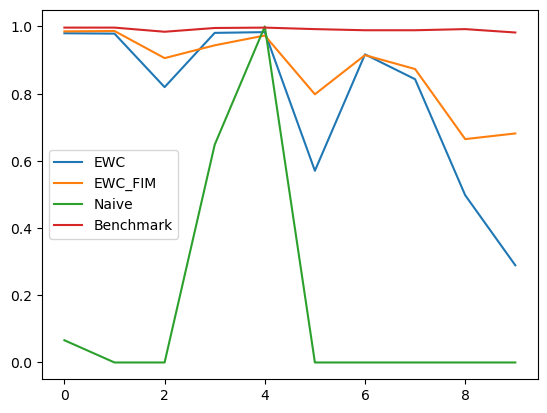

Computing clients information:   0%|          | 0/113 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.3230
Epoch 2/10, Loss: 12.8301
Epoch 3/10, Loss: 1.8772
Epoch 4/10, Loss: 3.1873
Epoch 5/10, Loss: 7.4434
Epoch 6/10, Loss: 5.6975
Epoch 7/10, Loss: 2.0260
Epoch 8/10, Loss: 0.7650
Epoch 9/10, Loss: 2.2618
Epoch 10/10, Loss: 3.8398


Computing clients information:   0%|          | 0/112 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7244
Epoch 2/10, Loss: 112.3337
Epoch 3/10, Loss: 8.0023
Epoch 4/10, Loss: 24.3875
Epoch 5/10, Loss: 64.8695
Epoch 6/10, Loss: 49.4145
Epoch 7/10, Loss: 14.8263
Epoch 8/10, Loss: 0.8147
Epoch 9/10, Loss: 14.0152
Epoch 10/10, Loss: 30.7693
cuda
Epoch 1/5, Loss: 5.1128
Epoch 2/5, Loss: 2.1164
Epoch 3/5, Loss: 0.7126
Epoch 4/5, Loss: 0.2219
Epoch 5/5, Loss: 0.0693


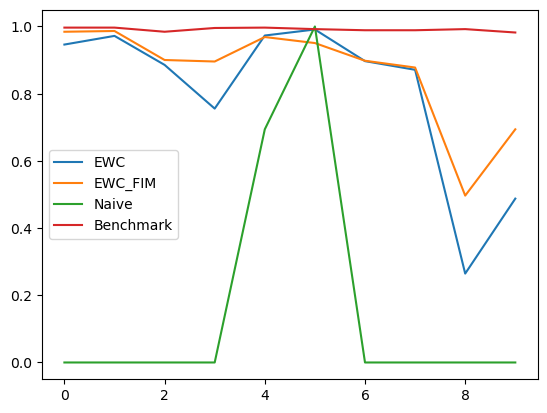

Computing clients information:   0%|          | 0/115 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4892
Epoch 2/10, Loss: 11.6337
Epoch 3/10, Loss: 1.2265
Epoch 4/10, Loss: 2.6799
Epoch 5/10, Loss: 6.8067
Epoch 6/10, Loss: 5.1481
Epoch 7/10, Loss: 1.6706
Epoch 8/10, Loss: 0.4089
Epoch 9/10, Loss: 1.7995
Epoch 10/10, Loss: 3.3824


Computing clients information:   0%|          | 0/114 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4247
Epoch 2/10, Loss: 117.0535
Epoch 3/10, Loss: 8.0681
Epoch 4/10, Loss: 25.1596
Epoch 5/10, Loss: 67.5341
Epoch 6/10, Loss: 51.4552
Epoch 7/10, Loss: 15.2913
Epoch 8/10, Loss: 0.5137
Epoch 9/10, Loss: 14.2092
Epoch 10/10, Loss: 31.8195
cuda
Epoch 1/5, Loss: 2.5921
Epoch 2/5, Loss: 1.1502
Epoch 3/5, Loss: 0.5418
Epoch 4/5, Loss: 0.2332
Epoch 5/5, Loss: 0.0838


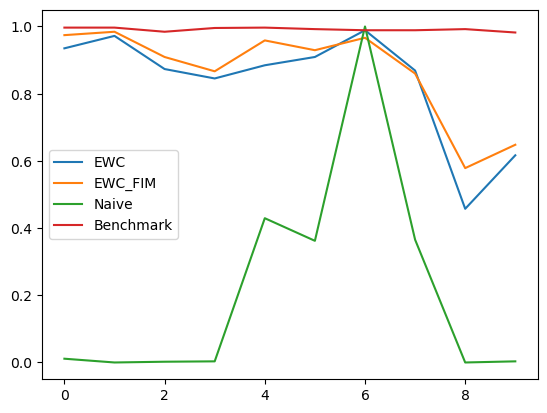

Computing clients information:   0%|          | 0/116 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3513
Epoch 2/10, Loss: 11.8541
Epoch 3/10, Loss: 1.1040
Epoch 4/10, Loss: 2.7069
Epoch 5/10, Loss: 6.9220
Epoch 6/10, Loss: 5.2769
Epoch 7/10, Loss: 1.6655
Epoch 8/10, Loss: 0.3546
Epoch 9/10, Loss: 1.7666
Epoch 10/10, Loss: 3.4054


Computing clients information:   0%|          | 0/116 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.3026
Epoch 2/10, Loss: 114.1653
Epoch 3/10, Loss: 7.7468
Epoch 4/10, Loss: 24.4453
Epoch 5/10, Loss: 65.8330
Epoch 6/10, Loss: 50.2140
Epoch 7/10, Loss: 14.9031
Epoch 8/10, Loss: 0.3726
Epoch 9/10, Loss: 13.6774
Epoch 10/10, Loss: 30.9286
cuda
Epoch 1/5, Loss: 1.7405
Epoch 2/5, Loss: 0.6359
Epoch 3/5, Loss: 0.1388
Epoch 4/5, Loss: 0.0213
Epoch 5/5, Loss: 0.0029


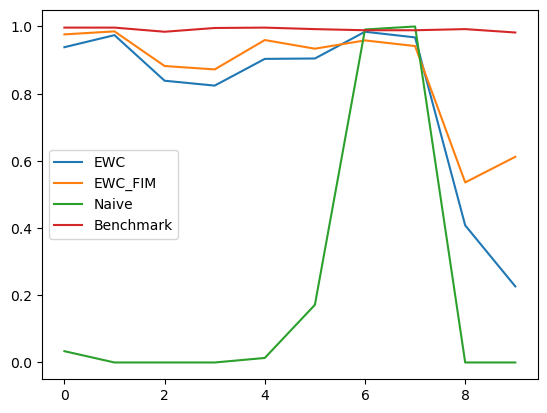

Computing clients information:   0%|          | 0/118 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.6883
Epoch 2/10, Loss: 12.6278
Epoch 3/10, Loss: 2.2015
Epoch 4/10, Loss: 3.2717
Epoch 5/10, Loss: 7.4621
Epoch 6/10, Loss: 5.8616
Epoch 7/10, Loss: 2.2651
Epoch 8/10, Loss: 0.9745
Epoch 9/10, Loss: 2.4096
Epoch 10/10, Loss: 3.9461


Computing clients information:   0%|          | 0/117 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.3451
Epoch 2/10, Loss: 111.5846
Epoch 3/10, Loss: 8.4893
Epoch 4/10, Loss: 24.6415
Epoch 5/10, Loss: 64.5821
Epoch 6/10, Loss: 49.2477
Epoch 7/10, Loss: 15.0816
Epoch 8/10, Loss: 1.4043
Epoch 9/10, Loss: 14.5749
Epoch 10/10, Loss: 30.9888
cuda
Epoch 1/5, Loss: 4.6326
Epoch 2/5, Loss: 2.2040
Epoch 3/5, Loss: 1.0641
Epoch 4/5, Loss: 0.5051
Epoch 5/5, Loss: 0.2094


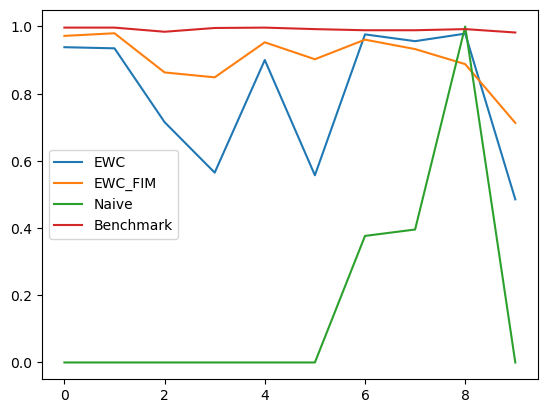

Computing clients information:   0%|          | 0/120 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2311
Epoch 2/10, Loss: 10.9480
Epoch 3/10, Loss: 1.6887
Epoch 4/10, Loss: 2.8063
Epoch 5/10, Loss: 6.4194
Epoch 6/10, Loss: 4.9327
Epoch 7/10, Loss: 1.8310
Epoch 8/10, Loss: 0.7394
Epoch 9/10, Loss: 1.9908
Epoch 10/10, Loss: 3.3468


Computing clients information:   0%|          | 0/119 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.8349
Epoch 2/10, Loss: 117.5764
Epoch 3/10, Loss: 8.4497
Epoch 4/10, Loss: 25.5757
Epoch 5/10, Loss: 67.9566
Epoch 6/10, Loss: 51.8143
Epoch 7/10, Loss: 15.6384
Epoch 8/10, Loss: 0.9282
Epoch 9/10, Loss: 14.6939
Epoch 10/10, Loss: 32.2520
cuda
Epoch 1/5, Loss: 3.1240
Epoch 2/5, Loss: 1.6461
Epoch 3/5, Loss: 1.0199
Epoch 4/5, Loss: 0.6540
Epoch 5/5, Loss: 0.3762


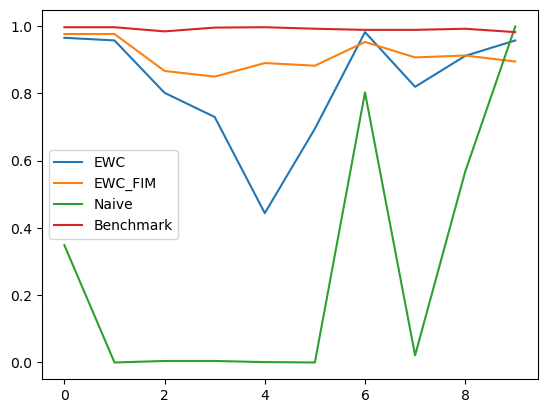

Computing clients information:   0%|          | 0/122 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2387
Epoch 2/10, Loss: 11.5996
Epoch 3/10, Loss: 1.0312
Epoch 4/10, Loss: 2.6082
Epoch 5/10, Loss: 6.7924
Epoch 6/10, Loss: 5.0829
Epoch 7/10, Loss: 1.5723
Epoch 8/10, Loss: 0.2870
Epoch 9/10, Loss: 1.6770
Epoch 10/10, Loss: 3.3008


Computing clients information:   0%|          | 0/121 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1902
Epoch 2/10, Loss: 119.4286
Epoch 3/10, Loss: 7.9994
Epoch 4/10, Loss: 25.5033
Epoch 5/10, Loss: 68.8394
Epoch 6/10, Loss: 52.4015
Epoch 7/10, Loss: 15.4498
Epoch 8/10, Loss: 0.2984
Epoch 9/10, Loss: 14.2410
Epoch 10/10, Loss: 32.2771
cuda
Epoch 1/5, Loss: 1.3021
Epoch 2/5, Loss: 0.4026
Epoch 3/5, Loss: 0.1069
Epoch 4/5, Loss: 0.0264
Epoch 5/5, Loss: 0.0060


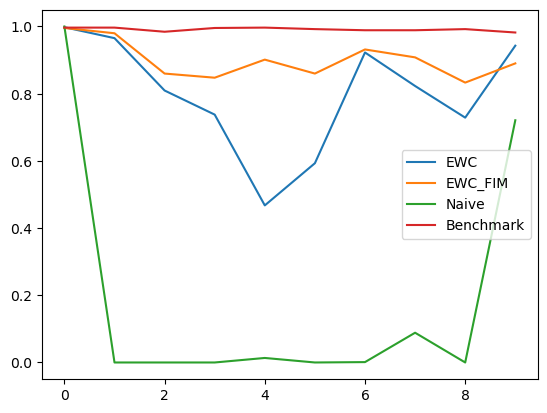

Computing clients information:   0%|          | 0/123 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2825
Epoch 2/10, Loss: 8.1671
Epoch 3/10, Loss: 0.8851
Epoch 4/10, Loss: 1.8955
Epoch 5/10, Loss: 4.8539
Epoch 6/10, Loss: 3.6697
Epoch 7/10, Loss: 1.2008
Epoch 8/10, Loss: 0.2940
Epoch 9/10, Loss: 1.2669
Epoch 10/10, Loss: 2.3960


Computing clients information:   0%|          | 0/123 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1360
Epoch 2/10, Loss: 122.1636
Epoch 3/10, Loss: 8.1322
Epoch 4/10, Loss: 26.0045
Epoch 5/10, Loss: 70.3905
Epoch 6/10, Loss: 53.7362
Epoch 7/10, Loss: 15.8853
Epoch 8/10, Loss: 0.2032
Epoch 9/10, Loss: 14.3918
Epoch 10/10, Loss: 32.9432
cuda
Epoch 1/5, Loss: 4.8073
Epoch 2/5, Loss: 2.0109
Epoch 3/5, Loss: 0.5282
Epoch 4/5, Loss: 0.1032
Epoch 5/5, Loss: 0.0226


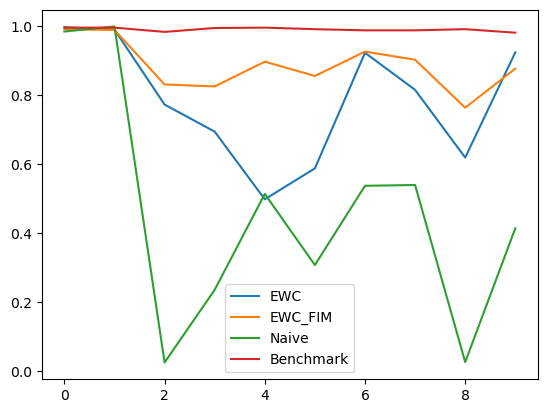

Computing clients information:   0%|          | 0/125 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7760
Epoch 2/10, Loss: 13.2138
Epoch 3/10, Loss: 1.5297
Epoch 4/10, Loss: 3.1653
Epoch 5/10, Loss: 7.7433
Epoch 6/10, Loss: 5.8945
Epoch 7/10, Loss: 2.0047
Epoch 8/10, Loss: 0.6056
Epoch 9/10, Loss: 2.1621
Epoch 10/10, Loss: 3.9148


Computing clients information:   0%|          | 0/124 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6092
Epoch 2/10, Loss: 129.7762
Epoch 3/10, Loss: 9.0513
Epoch 4/10, Loss: 28.0025
Epoch 5/10, Loss: 74.9099
Epoch 6/10, Loss: 57.1488
Epoch 7/10, Loss: 17.0992
Epoch 8/10, Loss: 0.6913
Epoch 9/10, Loss: 15.8444
Epoch 10/10, Loss: 35.3620
cuda
Epoch 1/5, Loss: 2.8730
Epoch 2/5, Loss: 1.0523
Epoch 3/5, Loss: 0.2624
Epoch 4/5, Loss: 0.0474
Epoch 5/5, Loss: 0.0072


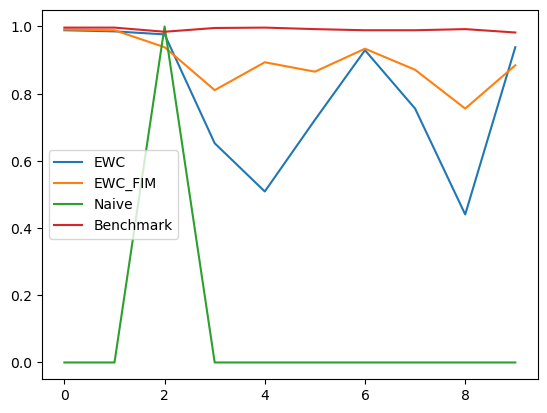

Computing clients information:   0%|          | 0/127 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.9692
Epoch 2/10, Loss: 12.3757
Epoch 3/10, Loss: 1.5726
Epoch 4/10, Loss: 2.9459
Epoch 5/10, Loss: 7.1799
Epoch 6/10, Loss: 5.4624
Epoch 7/10, Loss: 1.8683
Epoch 8/10, Loss: 0.6315
Epoch 9/10, Loss: 2.0650
Epoch 10/10, Loss: 3.6284


Computing clients information:   0%|          | 0/126 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5579
Epoch 2/10, Loss: 127.0248
Epoch 3/10, Loss: 8.8296
Epoch 4/10, Loss: 27.4007
Epoch 5/10, Loss: 73.2927
Epoch 6/10, Loss: 55.8243
Epoch 7/10, Loss: 16.6080
Epoch 8/10, Loss: 0.6791
Epoch 9/10, Loss: 15.5916
Epoch 10/10, Loss: 34.6171
cuda
Epoch 1/5, Loss: 4.6112
Epoch 2/5, Loss: 1.5698
Epoch 3/5, Loss: 0.4431
Epoch 4/5, Loss: 0.1609
Epoch 5/5, Loss: 0.0699


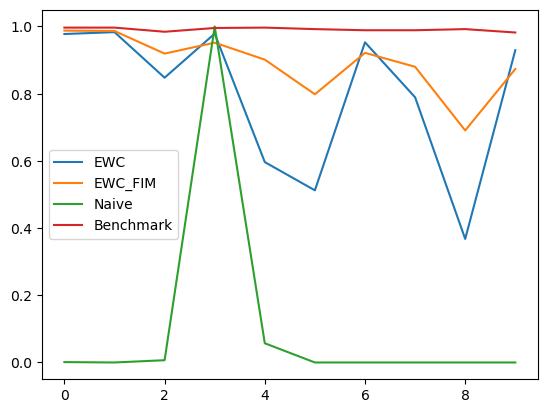

Computing clients information:   0%|          | 0/129 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.1552
Epoch 2/10, Loss: 12.2841
Epoch 3/10, Loss: 1.7278
Epoch 4/10, Loss: 3.0388
Epoch 5/10, Loss: 7.1649
Epoch 6/10, Loss: 5.4937
Epoch 7/10, Loss: 1.9517
Epoch 8/10, Loss: 0.6842
Epoch 9/10, Loss: 2.0927
Epoch 10/10, Loss: 3.6608


Computing clients information:   0%|          | 0/128 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5176
Epoch 2/10, Loss: 133.6595
Epoch 3/10, Loss: 9.2263
Epoch 4/10, Loss: 28.7589
Epoch 5/10, Loss: 77.1066
Epoch 6/10, Loss: 58.8119
Epoch 7/10, Loss: 17.5139
Epoch 8/10, Loss: 0.6026
Epoch 9/10, Loss: 16.2203
Epoch 10/10, Loss: 36.3329
cuda
Epoch 1/5, Loss: 1.8278
Epoch 2/5, Loss: 0.8317
Epoch 3/5, Loss: 0.3177
Epoch 4/5, Loss: 0.0935
Epoch 5/5, Loss: 0.0223


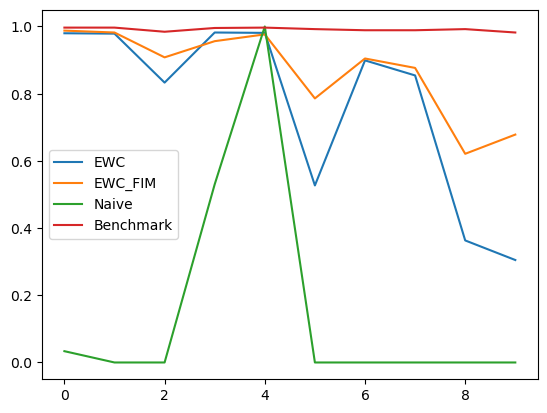

Computing clients information:   0%|          | 0/130 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2426
Epoch 2/10, Loss: 12.2444
Epoch 3/10, Loss: 1.7625
Epoch 4/10, Loss: 3.0524
Epoch 5/10, Loss: 7.1024
Epoch 6/10, Loss: 5.4337
Epoch 7/10, Loss: 1.9280
Epoch 8/10, Loss: 0.6972
Epoch 9/10, Loss: 2.1205
Epoch 10/10, Loss: 3.6467


Computing clients information:   0%|          | 0/129 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6774
Epoch 2/10, Loss: 136.5821
Epoch 3/10, Loss: 9.5515
Epoch 4/10, Loss: 29.4907
Epoch 5/10, Loss: 78.8330
Epoch 6/10, Loss: 60.1110
Epoch 7/10, Loss: 17.9771
Epoch 8/10, Loss: 0.7665
Epoch 9/10, Loss: 16.7540
Epoch 10/10, Loss: 37.2575
cuda
Epoch 1/5, Loss: 4.5445
Epoch 2/5, Loss: 1.8728
Epoch 3/5, Loss: 0.6453
Epoch 4/5, Loss: 0.2049
Epoch 5/5, Loss: 0.0632


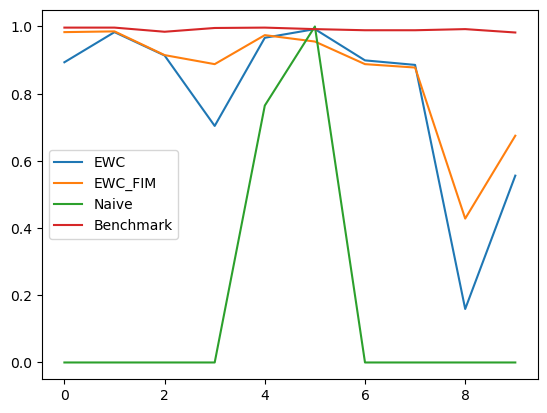

Computing clients information:   0%|          | 0/132 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5315
Epoch 2/10, Loss: 11.5474
Epoch 3/10, Loss: 1.2814
Epoch 4/10, Loss: 2.6675
Epoch 5/10, Loss: 6.7543
Epoch 6/10, Loss: 5.1364
Epoch 7/10, Loss: 1.6770
Epoch 8/10, Loss: 0.4293
Epoch 9/10, Loss: 1.8073
Epoch 10/10, Loss: 3.3728


Computing clients information:   0%|          | 0/131 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4821
Epoch 2/10, Loss: 140.8051
Epoch 3/10, Loss: 9.6608
Epoch 4/10, Loss: 30.2524
Epoch 5/10, Loss: 81.2169
Epoch 6/10, Loss: 61.8644
Epoch 7/10, Loss: 18.3783
Epoch 8/10, Loss: 0.6054
Epoch 9/10, Loss: 17.0578
Epoch 10/10, Loss: 38.2339
cuda
Epoch 1/5, Loss: 2.3698
Epoch 2/5, Loss: 1.0288
Epoch 3/5, Loss: 0.4403
Epoch 4/5, Loss: 0.1636
Epoch 5/5, Loss: 0.0508


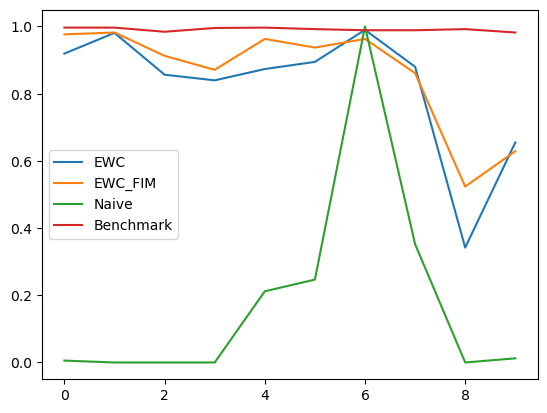

Computing clients information:   0%|          | 0/134 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.4735
Epoch 2/10, Loss: 12.1347
Epoch 3/10, Loss: 1.2219
Epoch 4/10, Loss: 2.8501
Epoch 5/10, Loss: 7.1427
Epoch 6/10, Loss: 5.4439
Epoch 7/10, Loss: 1.8028
Epoch 8/10, Loss: 0.4523
Epoch 9/10, Loss: 1.8699
Epoch 10/10, Loss: 3.5438


Computing clients information:   0%|          | 0/133 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5081
Epoch 2/10, Loss: 136.1833
Epoch 3/10, Loss: 9.3784
Epoch 4/10, Loss: 29.2663
Epoch 5/10, Loss: 78.5794
Epoch 6/10, Loss: 60.0041
Epoch 7/10, Loss: 17.9307
Epoch 8/10, Loss: 0.5791
Epoch 9/10, Loss: 16.4200
Epoch 10/10, Loss: 36.9972
cuda
Epoch 1/5, Loss: 1.8208
Epoch 2/5, Loss: 0.6687
Epoch 3/5, Loss: 0.1624
Epoch 4/5, Loss: 0.0275
Epoch 5/5, Loss: 0.0042


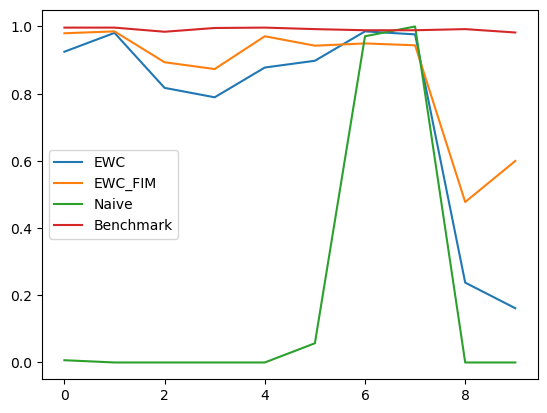

Computing clients information:   0%|          | 0/136 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 2.0649
Epoch 2/10, Loss: 12.0202
Epoch 3/10, Loss: 2.4853
Epoch 4/10, Loss: 3.2949
Epoch 5/10, Loss: 7.1902
Epoch 6/10, Loss: 5.7463
Epoch 7/10, Loss: 2.3417
Epoch 8/10, Loss: 1.0909
Epoch 9/10, Loss: 2.4314
Epoch 10/10, Loss: 3.8754


Computing clients information:   0%|          | 0/135 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.4485
Epoch 2/10, Loss: 134.8337
Epoch 3/10, Loss: 10.0928
Epoch 4/10, Loss: 29.6116
Epoch 5/10, Loss: 77.9893
Epoch 6/10, Loss: 59.6093
Epoch 7/10, Loss: 18.2546
Epoch 8/10, Loss: 1.4640
Epoch 9/10, Loss: 17.2940
Epoch 10/10, Loss: 37.3048
cuda
Epoch 1/5, Loss: 4.4132
Epoch 2/5, Loss: 2.1095
Epoch 3/5, Loss: 1.0495
Epoch 4/5, Loss: 0.5264
Epoch 5/5, Loss: 0.2309


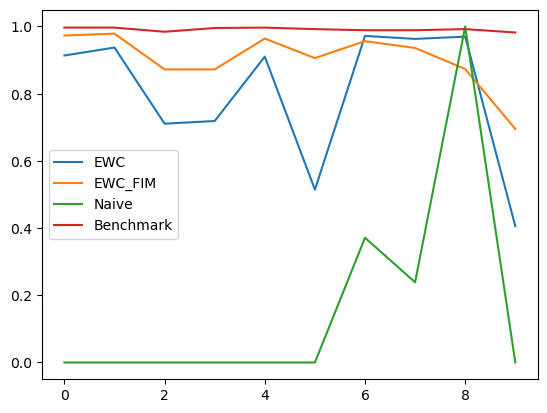

Computing clients information:   0%|          | 0/137 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.7890
Epoch 2/10, Loss: 12.6414
Epoch 3/10, Loss: 2.2308
Epoch 4/10, Loss: 3.4354
Epoch 5/10, Loss: 7.4810
Epoch 6/10, Loss: 5.8311
Epoch 7/10, Loss: 2.3099
Epoch 8/10, Loss: 1.0580
Epoch 9/10, Loss: 2.4435
Epoch 10/10, Loss: 3.9666


Computing clients information:   0%|          | 0/136 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.4430
Epoch 2/10, Loss: 141.4900
Epoch 3/10, Loss: 10.5709
Epoch 4/10, Loss: 31.0988
Epoch 5/10, Loss: 81.9286
Epoch 6/10, Loss: 62.5904
Epoch 7/10, Loss: 19.1760
Epoch 8/10, Loss: 1.5285
Epoch 9/10, Loss: 18.0527
Epoch 10/10, Loss: 39.1126
cuda
Epoch 1/5, Loss: 3.3257
Epoch 2/5, Loss: 1.7109
Epoch 3/5, Loss: 0.9526
Epoch 4/5, Loss: 0.5348
Epoch 5/5, Loss: 0.2707


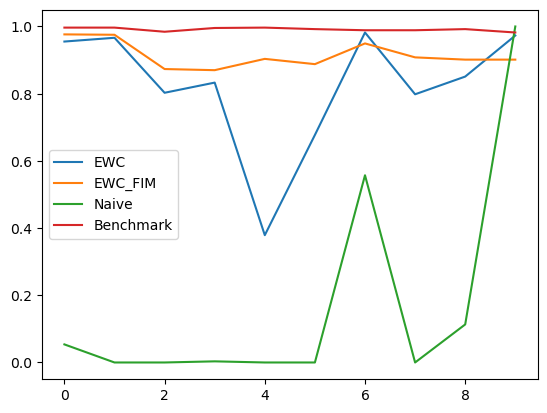

Computing clients information:   0%|          | 0/138 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2946
Epoch 2/10, Loss: 10.9788
Epoch 3/10, Loss: 1.0558
Epoch 4/10, Loss: 2.4539
Epoch 5/10, Loss: 6.3972
Epoch 6/10, Loss: 4.8007
Epoch 7/10, Loss: 1.4918
Epoch 8/10, Loss: 0.2961
Epoch 9/10, Loss: 1.6122
Epoch 10/10, Loss: 3.1260


Computing clients information:   0%|          | 0/138 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1706
Epoch 2/10, Loss: 140.8941
Epoch 3/10, Loss: 9.3900
Epoch 4/10, Loss: 30.0466
Epoch 5/10, Loss: 81.1933
Epoch 6/10, Loss: 61.8060
Epoch 7/10, Loss: 18.1937
Epoch 8/10, Loss: 0.3224
Epoch 9/10, Loss: 16.7513
Epoch 10/10, Loss: 38.0285
cuda
Epoch 1/5, Loss: 1.8314
Epoch 2/5, Loss: 0.6379
Epoch 3/5, Loss: 0.1960
Epoch 4/5, Loss: 0.0564
Epoch 5/5, Loss: 0.0156


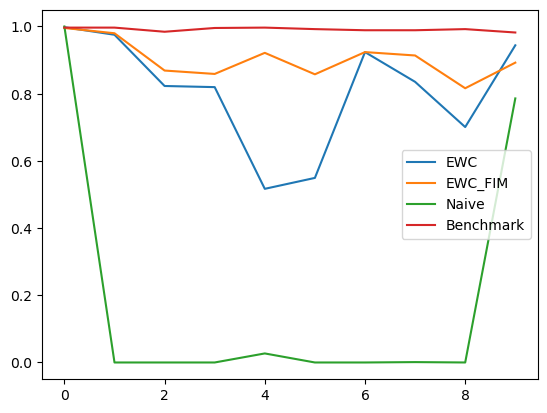

Computing clients information:   0%|          | 0/140 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.2991
Epoch 2/10, Loss: 8.5177
Epoch 3/10, Loss: 0.9381
Epoch 4/10, Loss: 1.9734
Epoch 5/10, Loss: 5.0545
Epoch 6/10, Loss: 3.8677
Epoch 7/10, Loss: 1.2582
Epoch 8/10, Loss: 0.2979
Epoch 9/10, Loss: 1.3182
Epoch 10/10, Loss: 2.5039


Computing clients information:   0%|          | 0/140 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.1746
Epoch 2/10, Loss: 144.8954
Epoch 3/10, Loss: 9.6752
Epoch 4/10, Loss: 30.8394
Epoch 5/10, Loss: 83.4944
Epoch 6/10, Loss: 63.7906
Epoch 7/10, Loss: 18.8905
Epoch 8/10, Loss: 0.2494
Epoch 9/10, Loss: 17.0536
Epoch 10/10, Loss: 39.0746
cuda
Epoch 1/5, Loss: 3.5352
Epoch 2/5, Loss: 1.4978
Epoch 3/5, Loss: 0.4506
Epoch 4/5, Loss: 0.1061
Epoch 5/5, Loss: 0.0251


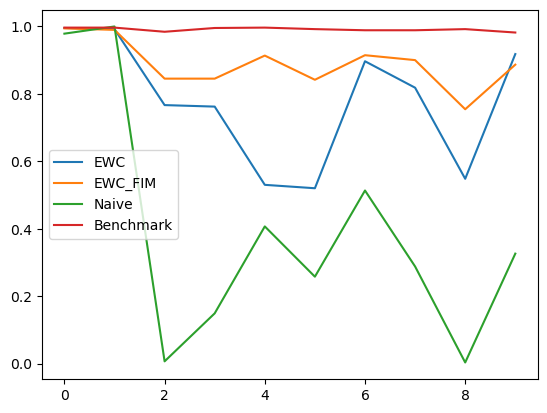

Computing clients information:   0%|          | 0/142 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.9405
Epoch 2/10, Loss: 13.2634
Epoch 3/10, Loss: 1.7175
Epoch 4/10, Loss: 3.2408
Epoch 5/10, Loss: 7.8141
Epoch 6/10, Loss: 6.0044
Epoch 7/10, Loss: 2.0954
Epoch 8/10, Loss: 0.6831
Epoch 9/10, Loss: 2.2321
Epoch 10/10, Loss: 3.9790


Computing clients information:   0%|          | 0/141 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.7776
Epoch 2/10, Loss: 154.0277
Epoch 3/10, Loss: 10.7875
Epoch 4/10, Loss: 33.2549
Epoch 5/10, Loss: 88.9356
Epoch 6/10, Loss: 67.8858
Epoch 7/10, Loss: 20.3715
Epoch 8/10, Loss: 0.8595
Epoch 9/10, Loss: 18.8006
Epoch 10/10, Loss: 41.9838
cuda
Epoch 1/5, Loss: 3.0069
Epoch 2/5, Loss: 1.3434
Epoch 3/5, Loss: 0.4566
Epoch 4/5, Loss: 0.1065
Epoch 5/5, Loss: 0.0183


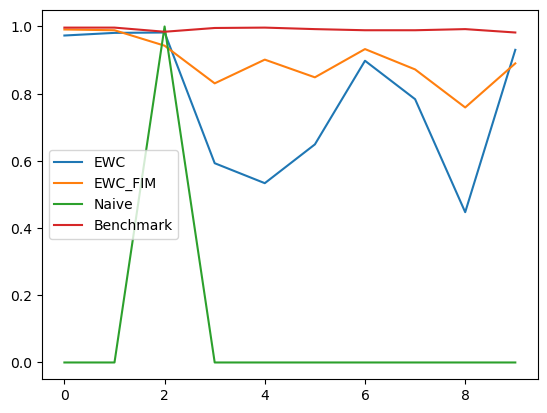

Computing clients information:   0%|          | 0/143 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.0667
Epoch 2/10, Loss: 12.8070
Epoch 3/10, Loss: 1.6425
Epoch 4/10, Loss: 3.0556
Epoch 5/10, Loss: 7.3829
Epoch 6/10, Loss: 5.6398
Epoch 7/10, Loss: 1.9210
Epoch 8/10, Loss: 0.6221
Epoch 9/10, Loss: 2.1007
Epoch 10/10, Loss: 3.7251


Computing clients information:   0%|          | 0/143 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5697
Epoch 2/10, Loss: 151.5512
Epoch 3/10, Loss: 10.4469
Epoch 4/10, Loss: 32.5823
Epoch 5/10, Loss: 87.4196
Epoch 6/10, Loss: 66.6613
Epoch 7/10, Loss: 19.8539
Epoch 8/10, Loss: 0.6723
Epoch 9/10, Loss: 18.3795
Epoch 10/10, Loss: 41.1950
cuda
Epoch 1/5, Loss: 4.7908
Epoch 2/5, Loss: 1.8477
Epoch 3/5, Loss: 0.5588
Epoch 4/5, Loss: 0.1930
Epoch 5/5, Loss: 0.0817


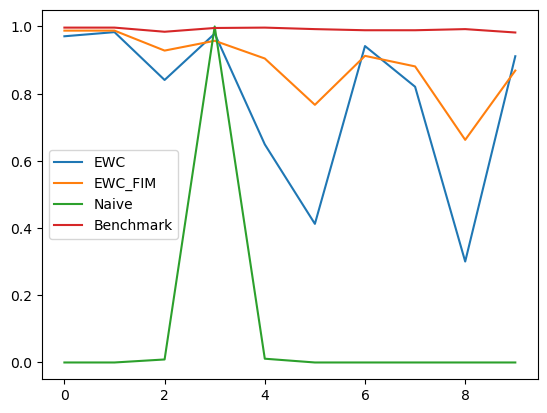

Computing clients information:   0%|          | 0/145 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.1017
Epoch 2/10, Loss: 11.8831
Epoch 3/10, Loss: 1.6931
Epoch 4/10, Loss: 2.9331
Epoch 5/10, Loss: 6.9650
Epoch 6/10, Loss: 5.3478
Epoch 7/10, Loss: 1.9101
Epoch 8/10, Loss: 0.6867
Epoch 9/10, Loss: 2.0470
Epoch 10/10, Loss: 3.5601


Computing clients information:   0%|          | 0/145 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5117
Epoch 2/10, Loss: 161.1288
Epoch 3/10, Loss: 11.0142
Epoch 4/10, Loss: 34.5572
Epoch 5/10, Loss: 92.9123
Epoch 6/10, Loss: 70.9118
Epoch 7/10, Loss: 21.1121
Epoch 8/10, Loss: 0.6087
Epoch 9/10, Loss: 19.3784
Epoch 10/10, Loss: 43.7058
cuda
Epoch 1/5, Loss: 1.9163
Epoch 2/5, Loss: 0.8473
Epoch 3/5, Loss: 0.3235
Epoch 4/5, Loss: 0.1006
Epoch 5/5, Loss: 0.0256


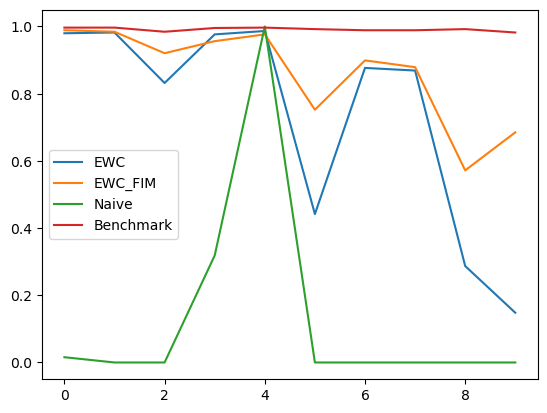

Computing clients information:   0%|          | 0/147 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 1.2716
Epoch 2/10, Loss: 11.9799
Epoch 3/10, Loss: 1.7869
Epoch 4/10, Loss: 2.9809
Epoch 5/10, Loss: 6.9607
Epoch 6/10, Loss: 5.3524
Epoch 7/10, Loss: 1.9130
Epoch 8/10, Loss: 0.7104
Epoch 9/10, Loss: 2.0913
Epoch 10/10, Loss: 3.5802


Computing clients information:   0%|          | 0/147 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6189
Epoch 2/10, Loss: 164.3590
Epoch 3/10, Loss: 11.3200
Epoch 4/10, Loss: 35.3317
Epoch 5/10, Loss: 94.7977
Epoch 6/10, Loss: 72.3348
Epoch 7/10, Loss: 21.5601
Epoch 8/10, Loss: 0.7217
Epoch 9/10, Loss: 19.9091
Epoch 10/10, Loss: 44.6675
cuda
Epoch 1/5, Loss: 4.0415
Epoch 2/5, Loss: 1.8396
Epoch 3/5, Loss: 0.7734
Epoch 4/5, Loss: 0.2991
Epoch 5/5, Loss: 0.1022


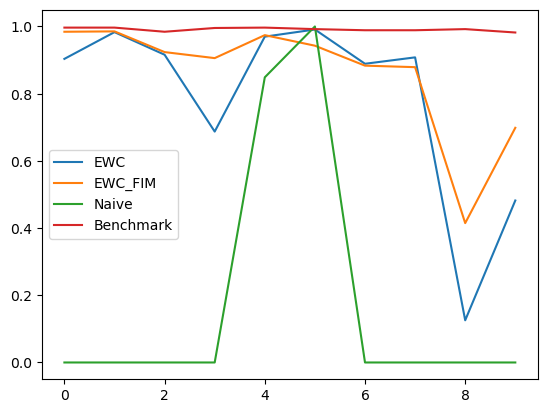

Computing clients information:   0%|          | 0/149 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.6567
Epoch 2/10, Loss: 10.8568
Epoch 3/10, Loss: 1.3663
Epoch 4/10, Loss: 2.5293
Epoch 5/10, Loss: 6.3576
Epoch 6/10, Loss: 4.8544
Epoch 7/10, Loss: 1.6215
Epoch 8/10, Loss: 0.4573
Epoch 9/10, Loss: 1.7531
Epoch 10/10, Loss: 3.2043


Computing clients information:   0%|          | 0/148 [00:00<?, ?batch/s]

cuda
Epoch 1/10, Loss: 0.5842
Epoch 2/10, Loss: 167.8795
Epoch 3/10, Loss: 11.5300
Epoch 4/10, Loss: 36.0491
Epoch 5/10, Loss: 96.8172
Epoch 6/10, Loss: 73.8093
Epoch 7/10, Loss: 21.9517
Epoch 8/10, Loss: 0.7137
Epoch 9/10, Loss: 20.3066
Epoch 10/10, Loss: 45.5696
cuda
Epoch 1/5, Loss: 2.3659
Epoch 2/5, Loss: 1.1538
Epoch 3/5, Loss: 0.5286
Epoch 4/5, Loss: 0.2005
Epoch 5/5, Loss: 0.0611


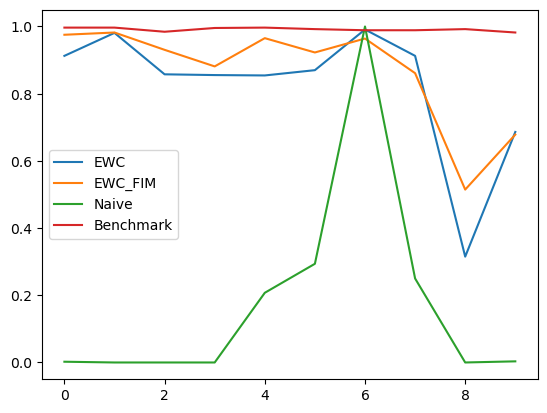

Computing clients information:   0%|          | 0/150 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [74]:
from fisherunlearn import compute_client_information
from fisherunlearn.clients_utils import concatenate_subsets
import fisherunlearn
fisherunlearn.set_info_batch_size(32)
fisherunlearn.set_device("cuda" if torch.cuda.is_available() else "cpu")

model_naive = FLNet()
model_ewc = FLNet()
model_fim = FLNet()
model_naive.load_state_dict(model.state_dict())
model_ewc.load_state_dict(model.state_dict())
model_fim.load_state_dict(model.state_dict())

for i, dataset in enumerate(rounds_datasets):
    # Compute the Fisher information matrix
    label = rounds_labels[i]
    seen_datasets_same_label = []
    seen_datasets_different_label = []
    for j, dataset_ in enumerate(initial_datasets):
        if label == j:
            seen_datasets_same_label.append(dataset_)
        else:
            seen_datasets_different_label.append(dataset_)
    for j, dataset_ in enumerate(rounds_datasets[:i]):
        if label == rounds_labels[j]:
            seen_datasets_same_label.append(dataset_)
        else:
            seen_datasets_different_label.append(dataset_)
    
    dataset_to_protect = concatenate_subsets(seen_datasets_different_label)
    dataset_remaining = concatenate_subsets(seen_datasets_same_label)
    
    information = compute_client_information(0, model_ewc, loss_fn, [dataset_to_protect, dataset_remaining])
    information = get_normalized_information(information)
    # Compute the EWC loss
    ewc_loss = EWC_loss(model_ewc, information, lambda_ewc=100000000, loss_fn=loss_fn)
    
    # Train the model with EWC
    model_ewc = trainer_ewc(model_ewc, ewc_loss, dataset, 10)
    plt.plot(compute_accuracies(model_ewc, classes_test_datasets), label="EWC")

    seen_dataset = concatenate_subsets([dataset_to_protect,dataset_remaining])
    fim_info = compute_client_information(0,model_fim,loss_fn,[seen_dataset],use_FIM=True)
    # Compute the EWC loss
    ewc_loss_fim = EWC_loss(model_fim, fim_info, lambda_ewc=1000000, loss_fn=loss_fn)
    model_fim = trainer_ewc(model_fim, ewc_loss_fim, dataset, 10)
    plt.plot(compute_accuracies(model_fim, classes_test_datasets), label="EWC_FIM")
    
    # Train the model without EWC
    model_naive = trainer(model_naive, loss_fn, dataset, 5)

    plt.plot(compute_accuracies(model_naive, classes_test_datasets), label="Naive")

    plt.plot(benchmark_accuracies, label="Benchmark")
    plt.legend()
    plt.show()